In [1]:
import numpy as np
import pandas as pd
from typing import Dict, Tuple
from scipy import stats
from IPython.display import Image
from io import StringIO 
from IPython.display import Image
import graphviz 
import pydotplus
from sklearn.datasets import load_iris, load_boston
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score 
from sklearn.metrics import roc_curve, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")

In [2]:
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    #Можно проверить все ли метки классов предсказываются
    #print(np.unique(Z))
    out = ax.contourf(xx, yy, Z, **params)
    return out


def plot_cl(clf):
    title = clf.__repr__
    clf.fit(iris_X, iris_y)
    fig, ax = plt.subplots(figsize=(5,5))
    X0, X1 = iris_X[:, 0], iris_X[:, 1]
    xx, yy = make_meshgrid(X0, X1)
    plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=iris_y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('Sepal length')
    ax.set_ylabel('Sepal width')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)
    plt.show()

In [3]:
from operator import itemgetter

def draw_feature_importances(tree_model, X_dataset, figsize=(10,5)):
    """
    Вывод важности признаков в виде графика
    """
    # Сортировка значений важности признаков по убыванию
    list_to_sort = list(zip(X_dataset.columns.values, tree_model.feature_importances_))
    sorted_list = sorted(list_to_sort, key=itemgetter(1), reverse = True)
    # Названия признаков
    labels = [x for x,_ in sorted_list]
    # Важности признаков
    data = [x for _,x in sorted_list]
    # Вывод графика
    fig, ax = plt.subplots(figsize=figsize)
    ind = np.arange(len(labels))
    plt.bar(ind, data)
    plt.xticks(ind, labels, rotation='vertical')
    # Вывод значений
    for a,b in zip(ind, data):
        plt.text(a-0.05, b+0.01, str(round(b,3)))
    plt.show()
    return labels, data

In [4]:
# Визуализация дерева
def get_png_tree(tree_model_param, feature_names_param):
    dot_data = StringIO()
    export_graphviz(tree_model_param, out_file=dot_data, feature_names=feature_names_param,
                    filled=True, rounded=True, special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    return graph.create_png()

In [5]:
def accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray) -> Dict[int, float]:
    """
    Вычисление метрики accuracy для каждого класса
    y_true - истинные значения классов
    y_pred - предсказанные значения классов
    Возвращает словарь: ключ - метка класса, 
    значение - Accuracy для данного класса
    """
    # Для удобства фильтрации сформируем Pandas DataFrame 
    d = {'t': y_true, 'p': y_pred}
    df = pd.DataFrame(data=d)
    # Метки классов
    classes = np.unique(y_true)
    # Результирующий словарь
    res = dict()
    # Перебор меток классов
    for c in classes:
        # отфильтруем данные, которые соответствуют 
        # текущей метке класса в истинных значениях
        temp_data_flt = df[df['t']==c]
        # расчет accuracy для заданной метки класса
        temp_acc = accuracy_score(
            temp_data_flt['t'].values, 
            temp_data_flt['p'].values)
        # сохранение результата в словарь
        res[c] = temp_acc
    return res

def print_accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray):
    """
    Вывод метрики accuracy для каждого класса
    """
    accs = accuracy_score_for_classes(y_true, y_pred)
    if len(accs)>0:
        print('Метка \t Accuracy')
    for i in accs:
        print('{} \t {}'.format(i, accs[i]))

# Использование [ансамблевых моделей](https://ru.wikipedia.org/wiki/%D0%90%D0%BD%D1%81%D0%B0%D0%BC%D0%B1%D0%BB%D1%8C_%D0%BC%D0%B5%D1%82%D0%BE%D0%B4%D0%BE%D0%B2_(%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D0%B5_%D0%BC%D0%B0%D1%88%D0%B8%D0%BD)) (или композиции моделей). Часть 1.

Идея использования ансамблевых моделей состоит в том, что оценивается результат совместного голосования различных моделей. Варианты объединения моделей в ансамбль могут быть различными и могут использоваться для решения различных задач.

В ансамблевых моделях часто используют такие термины как "сильный ученик" или "сильная модель" (strong learner) и "слабый ученик" или "слабая модель" (weak learner). На основе набора "слабых моделей" строится ансамбль, который является "сильной моделью".

Использование ансамблевых моделей поддерживается в [scikit-learn,](https://scikit-learn.org/stable/modules/ensemble.html) и также в других библиотеках (в основном, для градиентного бустинга).

**Содержание. Часть 1**
1. Обработка выборок с использованием бутстрепа
1. Бэггинг
1. Случайный лес
1. Бустинг


Вспомним, что в соответствии с [дилеммой смещения–дисперсии](https://ru.wikipedia.org/wiki/%D0%94%D0%B8%D0%BB%D0%B5%D0%BC%D0%BC%D0%B0_%D1%81%D0%BC%D0%B5%D1%89%D0%B5%D0%BD%D0%B8%D1%8F%E2%80%93%D0%B4%D0%B8%D1%81%D0%BF%D0%B5%D1%80%D1%81%D0%B8%D0%B8) невозможно одновременно улучшить и смещение и дисперсию модели.

Поэтому некоторые ансамблевые классификаторы ориентированы на уменьшение дисперсии, а некоторые на уменьшение смещения.

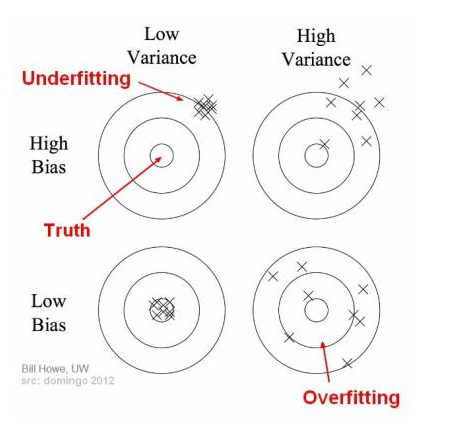

In [6]:
Image('img/bv1.png', width='30%')

## Бутстрэп

Метод бутстрэпа заключается в следующем. Пусть имеется выборка $X$ размера $N$. Равномерно возьмем из выборки $N$ объектов с возвращением. Это означает, что мы будем $N$ раз выбирать произвольный объект выборки (считаем, что каждый объект «достается» с одинаковой вероятностью $\frac{1}{N}$), причем каждый раз мы выбираем из всех исходных $N$ объектов. Можно представить себе мешок, из которого достают шарики: выбранный на каком-то шаге шарик возвращается обратно в мешок, и следующий выбор опять делается равновероятно из того же числа шариков. Отметим, что из-за возвращения среди них окажутся повторы. Обозначим новую выборку через $X_1$. Повторяя процедуру K раз, сгенерируем K подвыборок $X_1$ ... $X_K$. Теперь мы имеем достаточно большое число выборок и можем оценивать различные статистики исходного распределения.

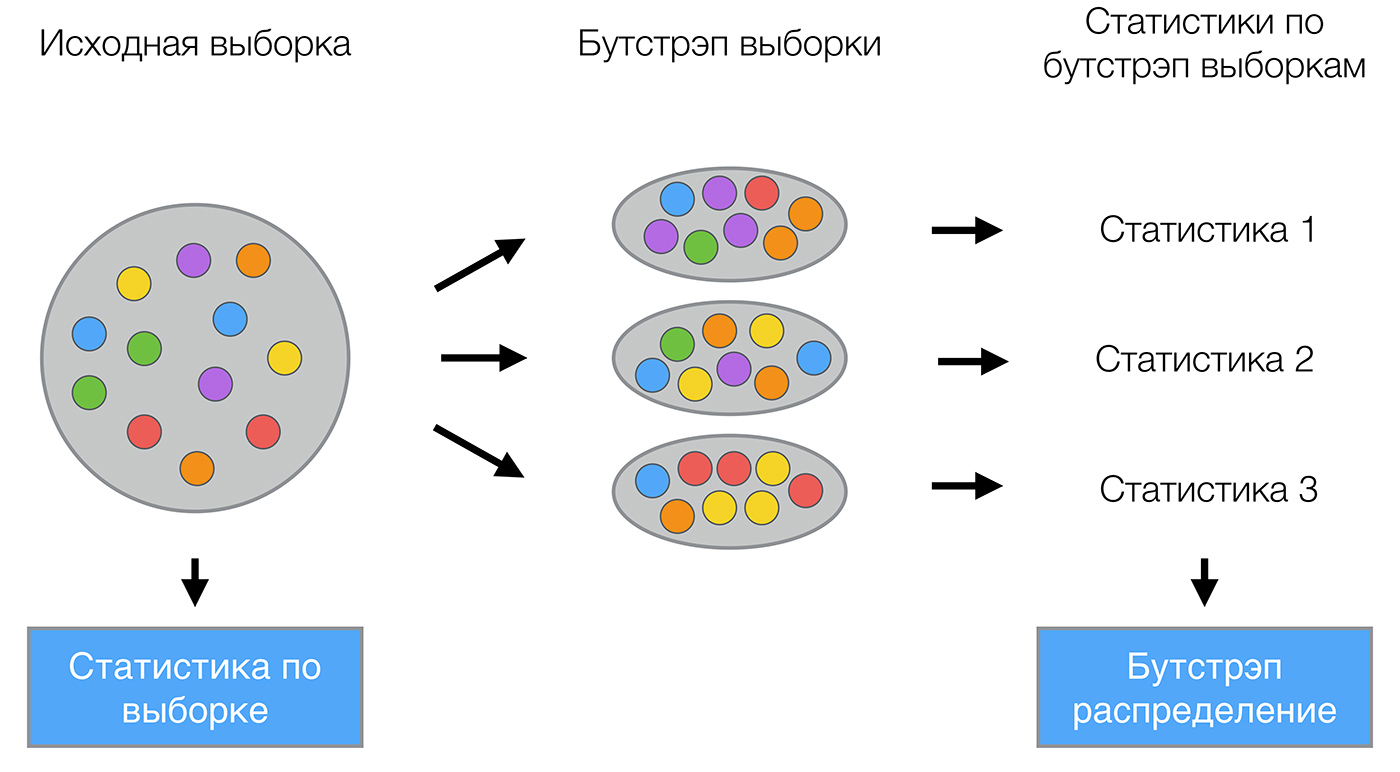

In [7]:
Image('img/bootstrap.jpg', width='50%')

## Бэггинг

Bagging (от Bootstrap aggregation) — это один из первых и самых простых видов ансамблей. Он был придуман Лео Брейманом в 1994 году. Бэггинг основан на статистическом методе бутстрэпа.

Пусть имеется обучающая выборка $X$ размера $N$. С помощью бутстрэпа сгенерируем из этой выборки $K$ подвыборок $X_1$ ... $X_K$. Теперь на каждой выборке обучим свою модель $M_i(x)$. Итоговый классификатор будет усреднять ответы всех моделей (выбирать средний результат голосования): $M(x) = \frac{1}{K} \sum\limits_{i=1}^K M_i(x)$

Бэггинг позволяет **снизить дисперсию (variance)** обучаемого классификатора, уменьшая величину, на которую ошибка будет отличаться, если обучать модель на разных наборах данных, или другими словами, предотвращает переобучение. Эффективность бэггинга достигается благодаря тому, что базовые алгоритмы, обученные по различным подвыборкам, получаются достаточно различными (**что характерно для решающего дерева**), и их ошибки взаимно компенсируются при голосовании, а также за счёт того, что объекты-выбросы могут не попадать в некоторые обучающие подвыборки.

**Важно** то что модель бэггинга строится на ансамбле **разных** обучающих выборок, но **одинаковых** моделей.

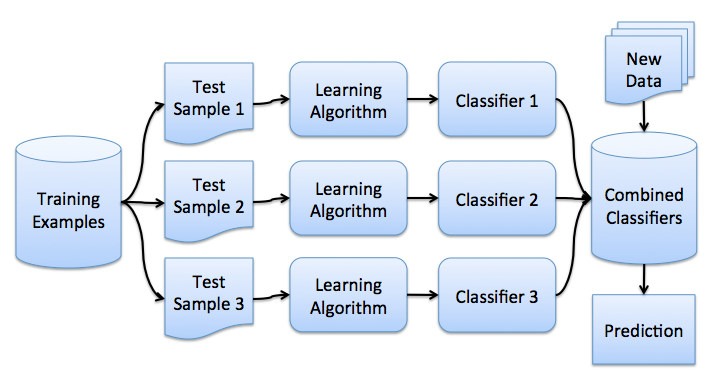

In [8]:
Image('img/bagging.png', width='50%')

### Out-of-bag error

В бэггинге и моделях на основе бэггинга (в том числе, в модели случайного леса) нет необходимости в кросс-валидации или в отдельном тестовом наборе, чтобы получить несмещенную оценку ошибки набора тестов. Посмотрим, как получается "внутренняя" оценка модели во время ее обучения.

Каждое дерево строится с использованием разных образцов бутстрэпа из исходных данных. Примерно 37% примеров остаются вне выборки бутстрэпа и не используются при построении k-го дерева. 

Это можно легко доказать: пусть в выборке $N$ объектов. На каждом шаге все объекты попадают в подвыборку с возвращением равновероятно, т.е отдельный объект попадают в подвыборку с вероятностью $\frac{1}{N}$. Вероятность того, что объект НЕ попадет в подвыборку (т.е. его не взяли $N$ раз): $(1-\frac{1}{N})^N$. При $N$ стремящемся к бесконечности получаем второй "замечательный" предел, значение которого $\frac{1}{e}$. Тогда вероятность попадания конкретного объекта в подвыборку приближенно равна $1-\frac{1}{e}$ что составляет около 63%. 

Таким образом, примерно 100%-63%=37% примеров остаются вне выборки бутстрэпа и не используются при построении k-го дерева. Такие объекты могут быть использованы в качестве тестовой выборки.

### Реализация в scikit-learn

Метод бэггинга реализуется в scikit-learn с помощью классов [BaggingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) и [BaggingRegressor.](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html)

#### Изучение BaggingClassifier

In [9]:
# Используем датасет iris с двумя первыми признаками
iris = load_iris()
iris_X = iris.data[:, :2]
iris_y = iris.target

In [10]:
# Обучим классификатор на 5 деревьях
bc1 = BaggingClassifier(n_estimators=5, oob_score=True, random_state=10)
bc1.fit(iris_X, iris_y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:642: RuntimeWarning: invalid value encountered in true_divide
  oob_decision_function = (predictions /


BaggingClassifier(n_estimators=5, oob_score=True, random_state=10)

In [11]:
# Какие объекты были использованы в обучающей выборке каждого дерева
bc1.estimators_samples_

[array([137, 103, 142, 138,  26, 138,  50, 126,  67,  34,  24,  43, 149,
         58, 112, 118, 104,  46, 104,  27,  74, 147,  37,  45, 132,  44,
        142,  69,  74,  23, 108,  64,   0,  50,  78,  42, 112,  77,  50,
          4, 114,  14,  56, 105,  43,  39,  43, 139,  80, 127, 116,  56,
         54, 110, 138, 136,   4,  79,  62,  44,  60, 111,  74, 114, 125,
        137, 102,  88,  14, 130, 107, 110, 118,  41,  62,  66,  37,  14,
         52, 120, 117,  68,  73,  39, 104,  92,  44, 139,  22,  66, 107,
         27,  85,  54,  40, 146,  95,  38,  92,  97,  61, 116,  73, 116,
         68,  48,  20, 124,  82,  37,  58, 101,   7, 123, 141, 146,  38,
        116, 105,  91,   7,   0, 131,   3,  22,  59, 133,  20, 106, 123,
         11, 121,  66,  18,  46,  52, 147,  62,  89,  86,  37, 115, 132,
         38,  90,  84,  86,  25,  48,  77]),
 array([ 95,  46,  93, 129,  44, 136,  87, 149,  61,  68,  87, 102,  31,
         34,  17,  58,  38,  79, 149,  88,  70,  22,  88, 112, 115,  52,
      

In [12]:
# Сконвертируем эти данные в двоичную матрицу, 
# 1 соответствует элементам, попавшим в обучающую выборку
bin_array = np.zeros((5, iris_X.shape[0]))
for i in range(5):
    for j in bc1.estimators_samples_[i]:
        bin_array[i][j] = 1
bin_array

array([[1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0.,
        0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
        1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0.,
        1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1.,
        1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1.,
        0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
        1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1.,
        0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0.,
        0., 0., 1., 1., 0., 1.],
       [1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1.,
        0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1.,
        0., 0., 1., 1., 1., 0.,

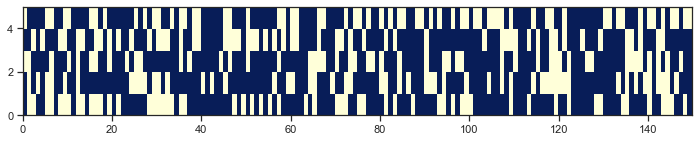

In [13]:
# И визуализируем (синим цветом показаны данные, которые попали в обучающую выборку)
fig, ax = plt.subplots(figsize=(12,2))
ax.pcolor(bin_array, cmap='YlGnBu')
plt.show()

In [14]:
# Оценим Out-of-bag error, теоретическое значение 37%
for i in range(5):
    cur_data = bin_array[i]
    len_cur_data = len(cur_data)
    sum_cur_data = sum(cur_data)
    (len(bin_array[0]) - sum(bin_array[0])) / len(bin_array[0])
    oob_i = (len_cur_data - sum_cur_data) / len_cur_data
    print('Для модели № {} размер OOB составляет {}%'.format(i+1, round(oob_i, 4)*100.0))

Для модели № 1 размер OOB составляет 38.0%
Для модели № 2 размер OOB составляет 35.33%
Для модели № 3 размер OOB составляет 33.33%
Для модели № 4 размер OOB составляет 36.67%
Для модели № 5 размер OOB составляет 42.67%


In [15]:
# Out-of-bag error, возвращаемый классификатором
bc1.oob_score_, 1-bc1.oob_score_

(0.6933333333333334, 0.30666666666666664)

In [16]:
# Параметр oob_decision_function_ возвращает вероятности 
# принадлежности объекта к классам на основе oob
# В данном примере три класса, 
# значения nan могут возвращаться в случае маленькой выборки
bc1.oob_decision_function_[55:70]

array([[0.        , 0.        , 1.        ],
       [0.        , 0.        , 1.        ],
       [0.        , 0.33333333, 0.66666667],
       [0.        , 0.5       , 0.5       ],
       [0.        , 1.        , 0.        ],
       [0.        , 1.        , 0.        ],
       [0.        , 0.5       , 0.5       ],
       [       nan,        nan,        nan],
       [0.        , 0.5       , 0.5       ],
       [0.        , 1.        , 0.        ],
       [0.        , 0.83333333, 0.16666667],
       [0.        , 1.        , 0.        ],
       [0.        , 0.25      , 0.75      ],
       [       nan,        nan,        nan],
       [0.        , 0.        , 1.        ]])

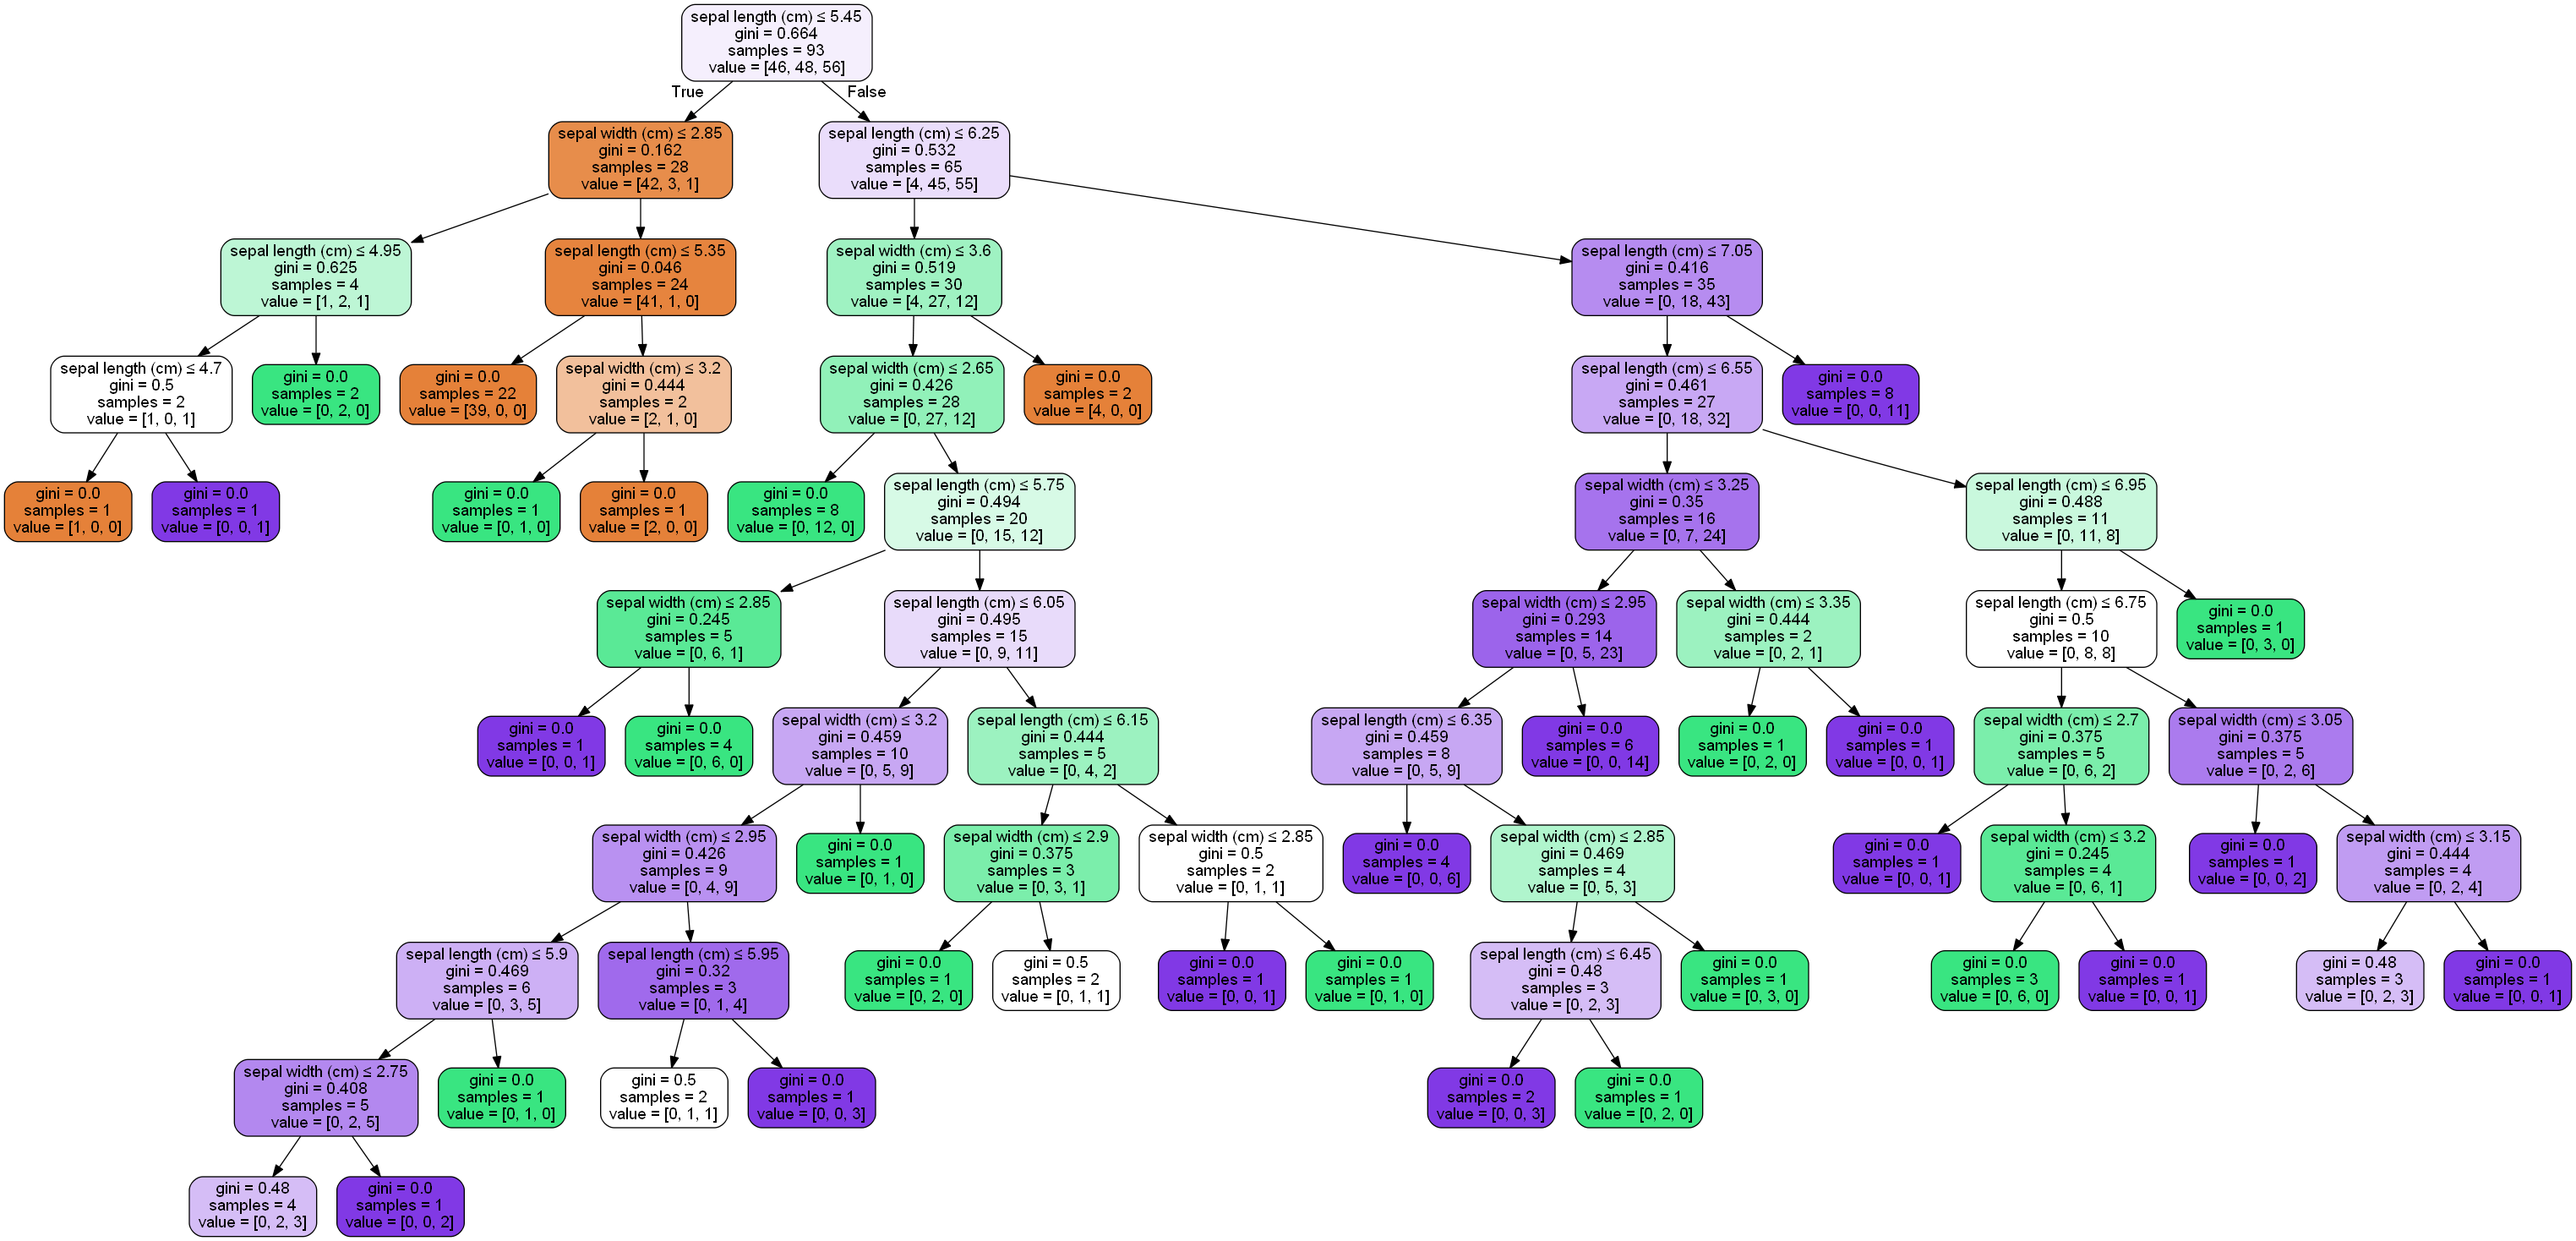

In [17]:
# Визуализация обученных решающих деревьев
Image(get_png_tree(bc1.estimators_[0], iris.feature_names[:2]), width='80%')

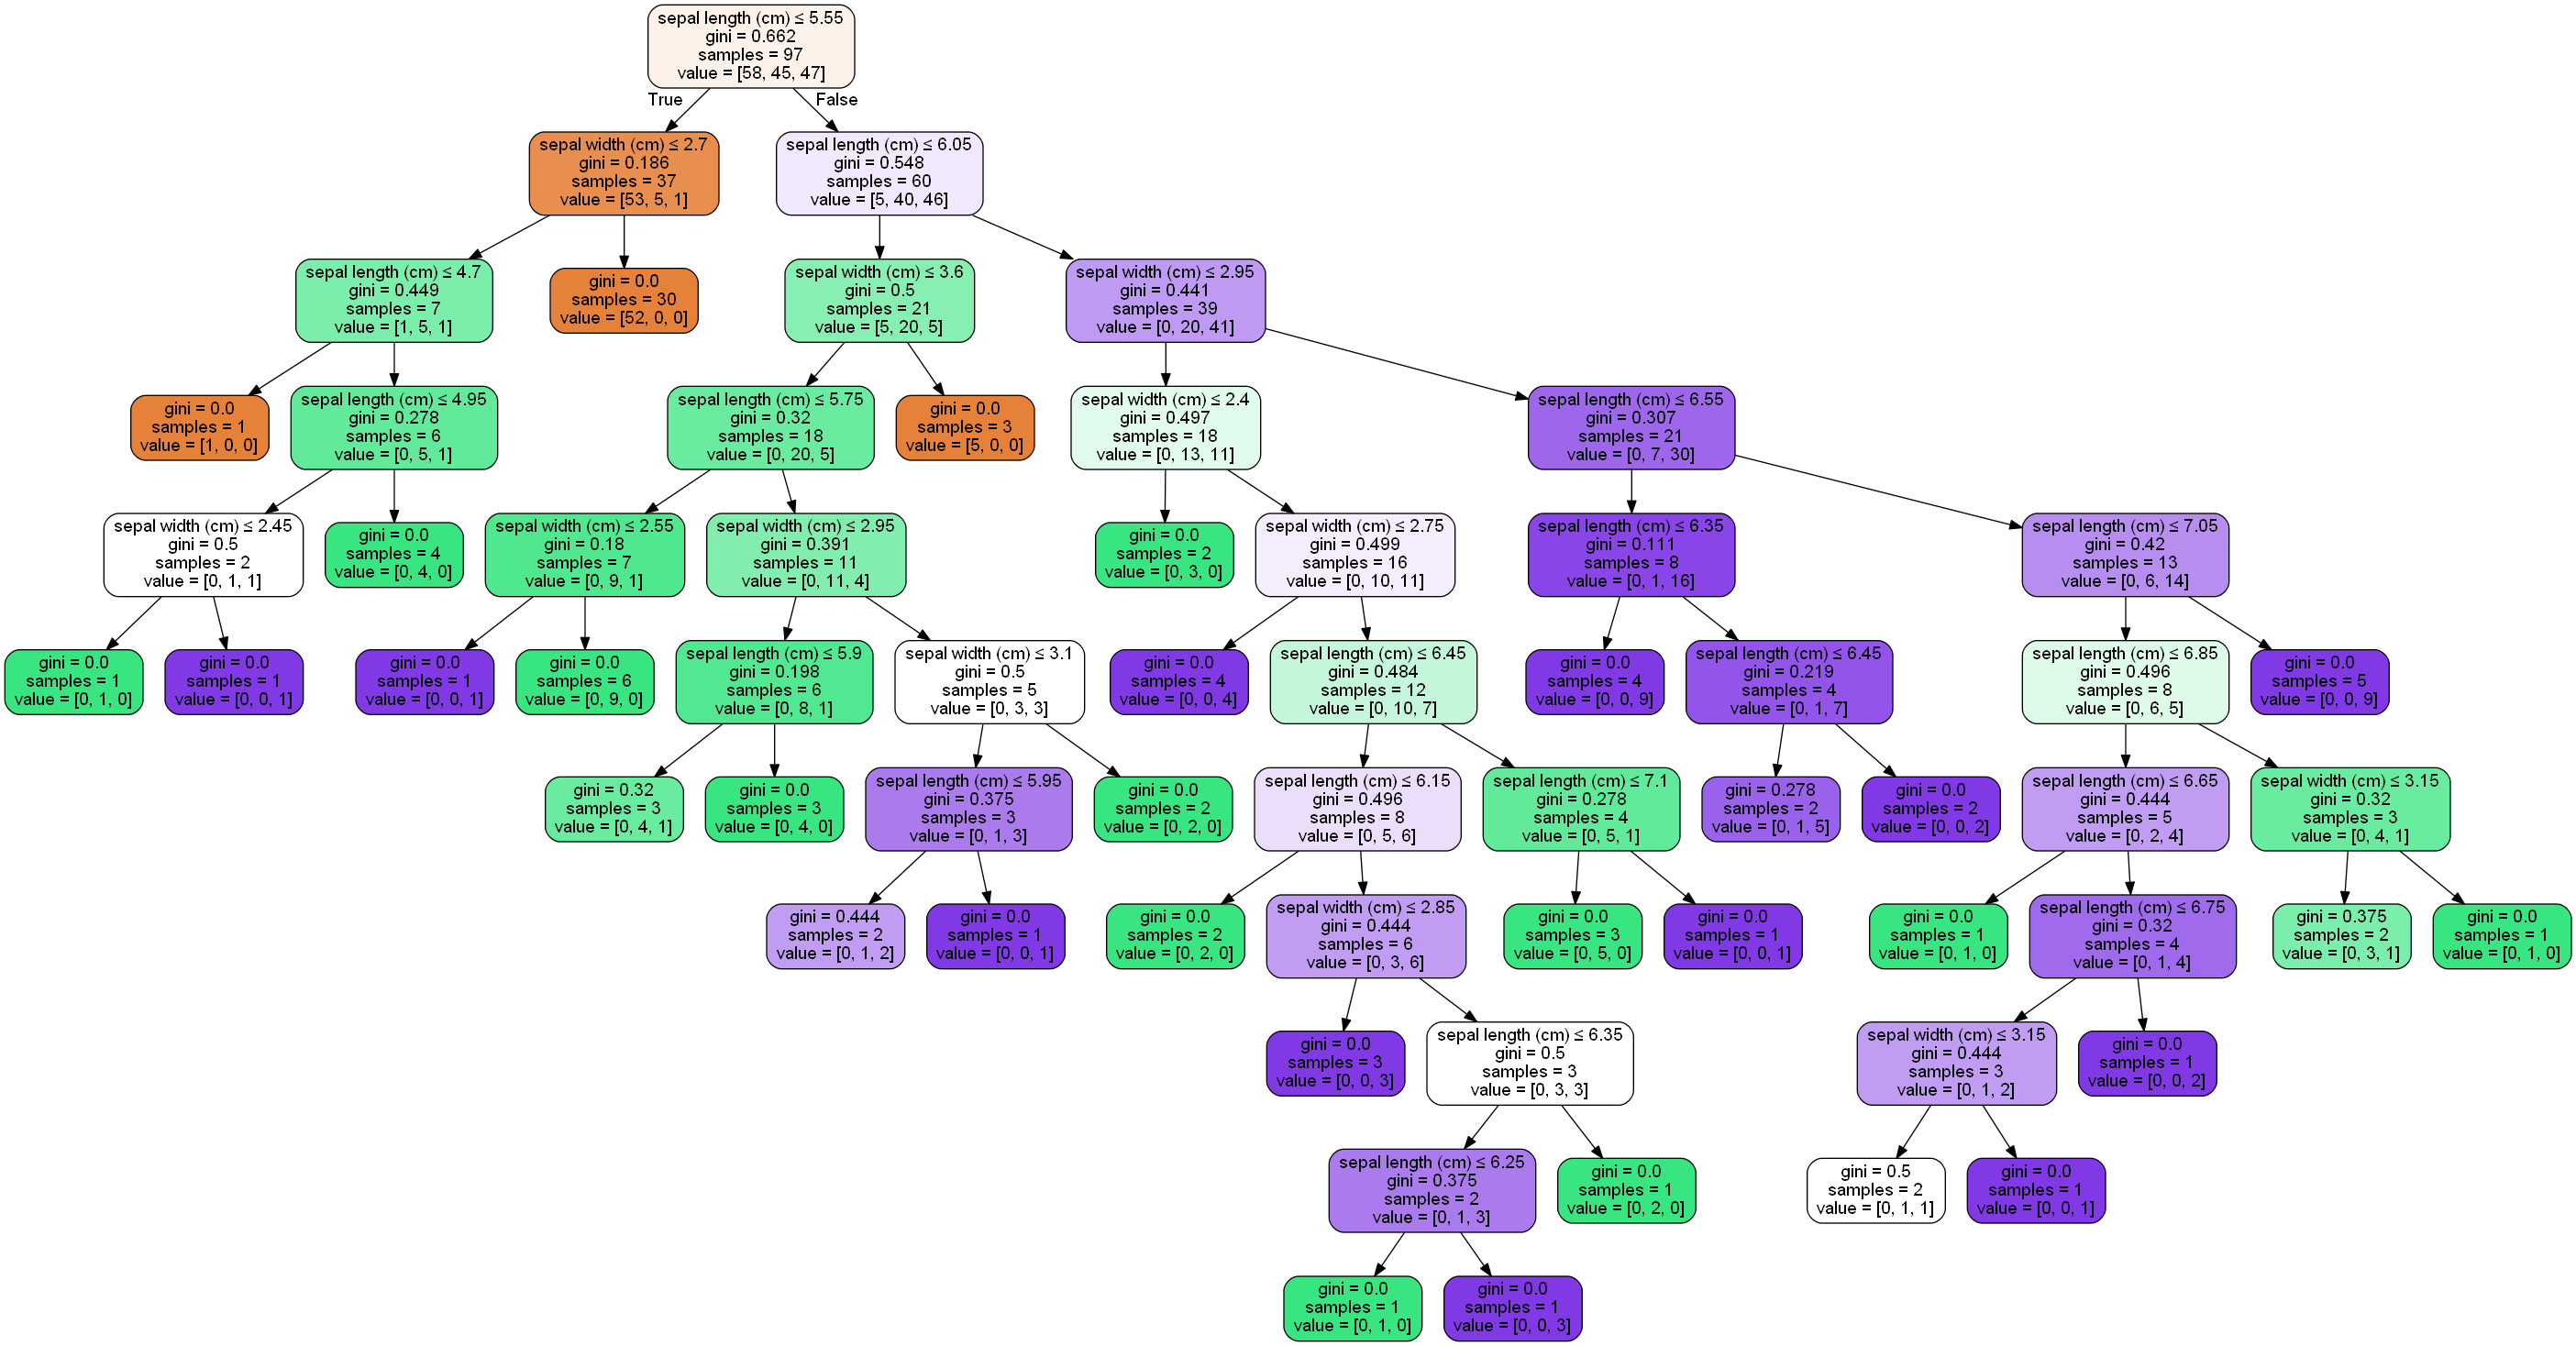

In [18]:
Image(get_png_tree(bc1.estimators_[1], iris.feature_names[:2]), width='80%')

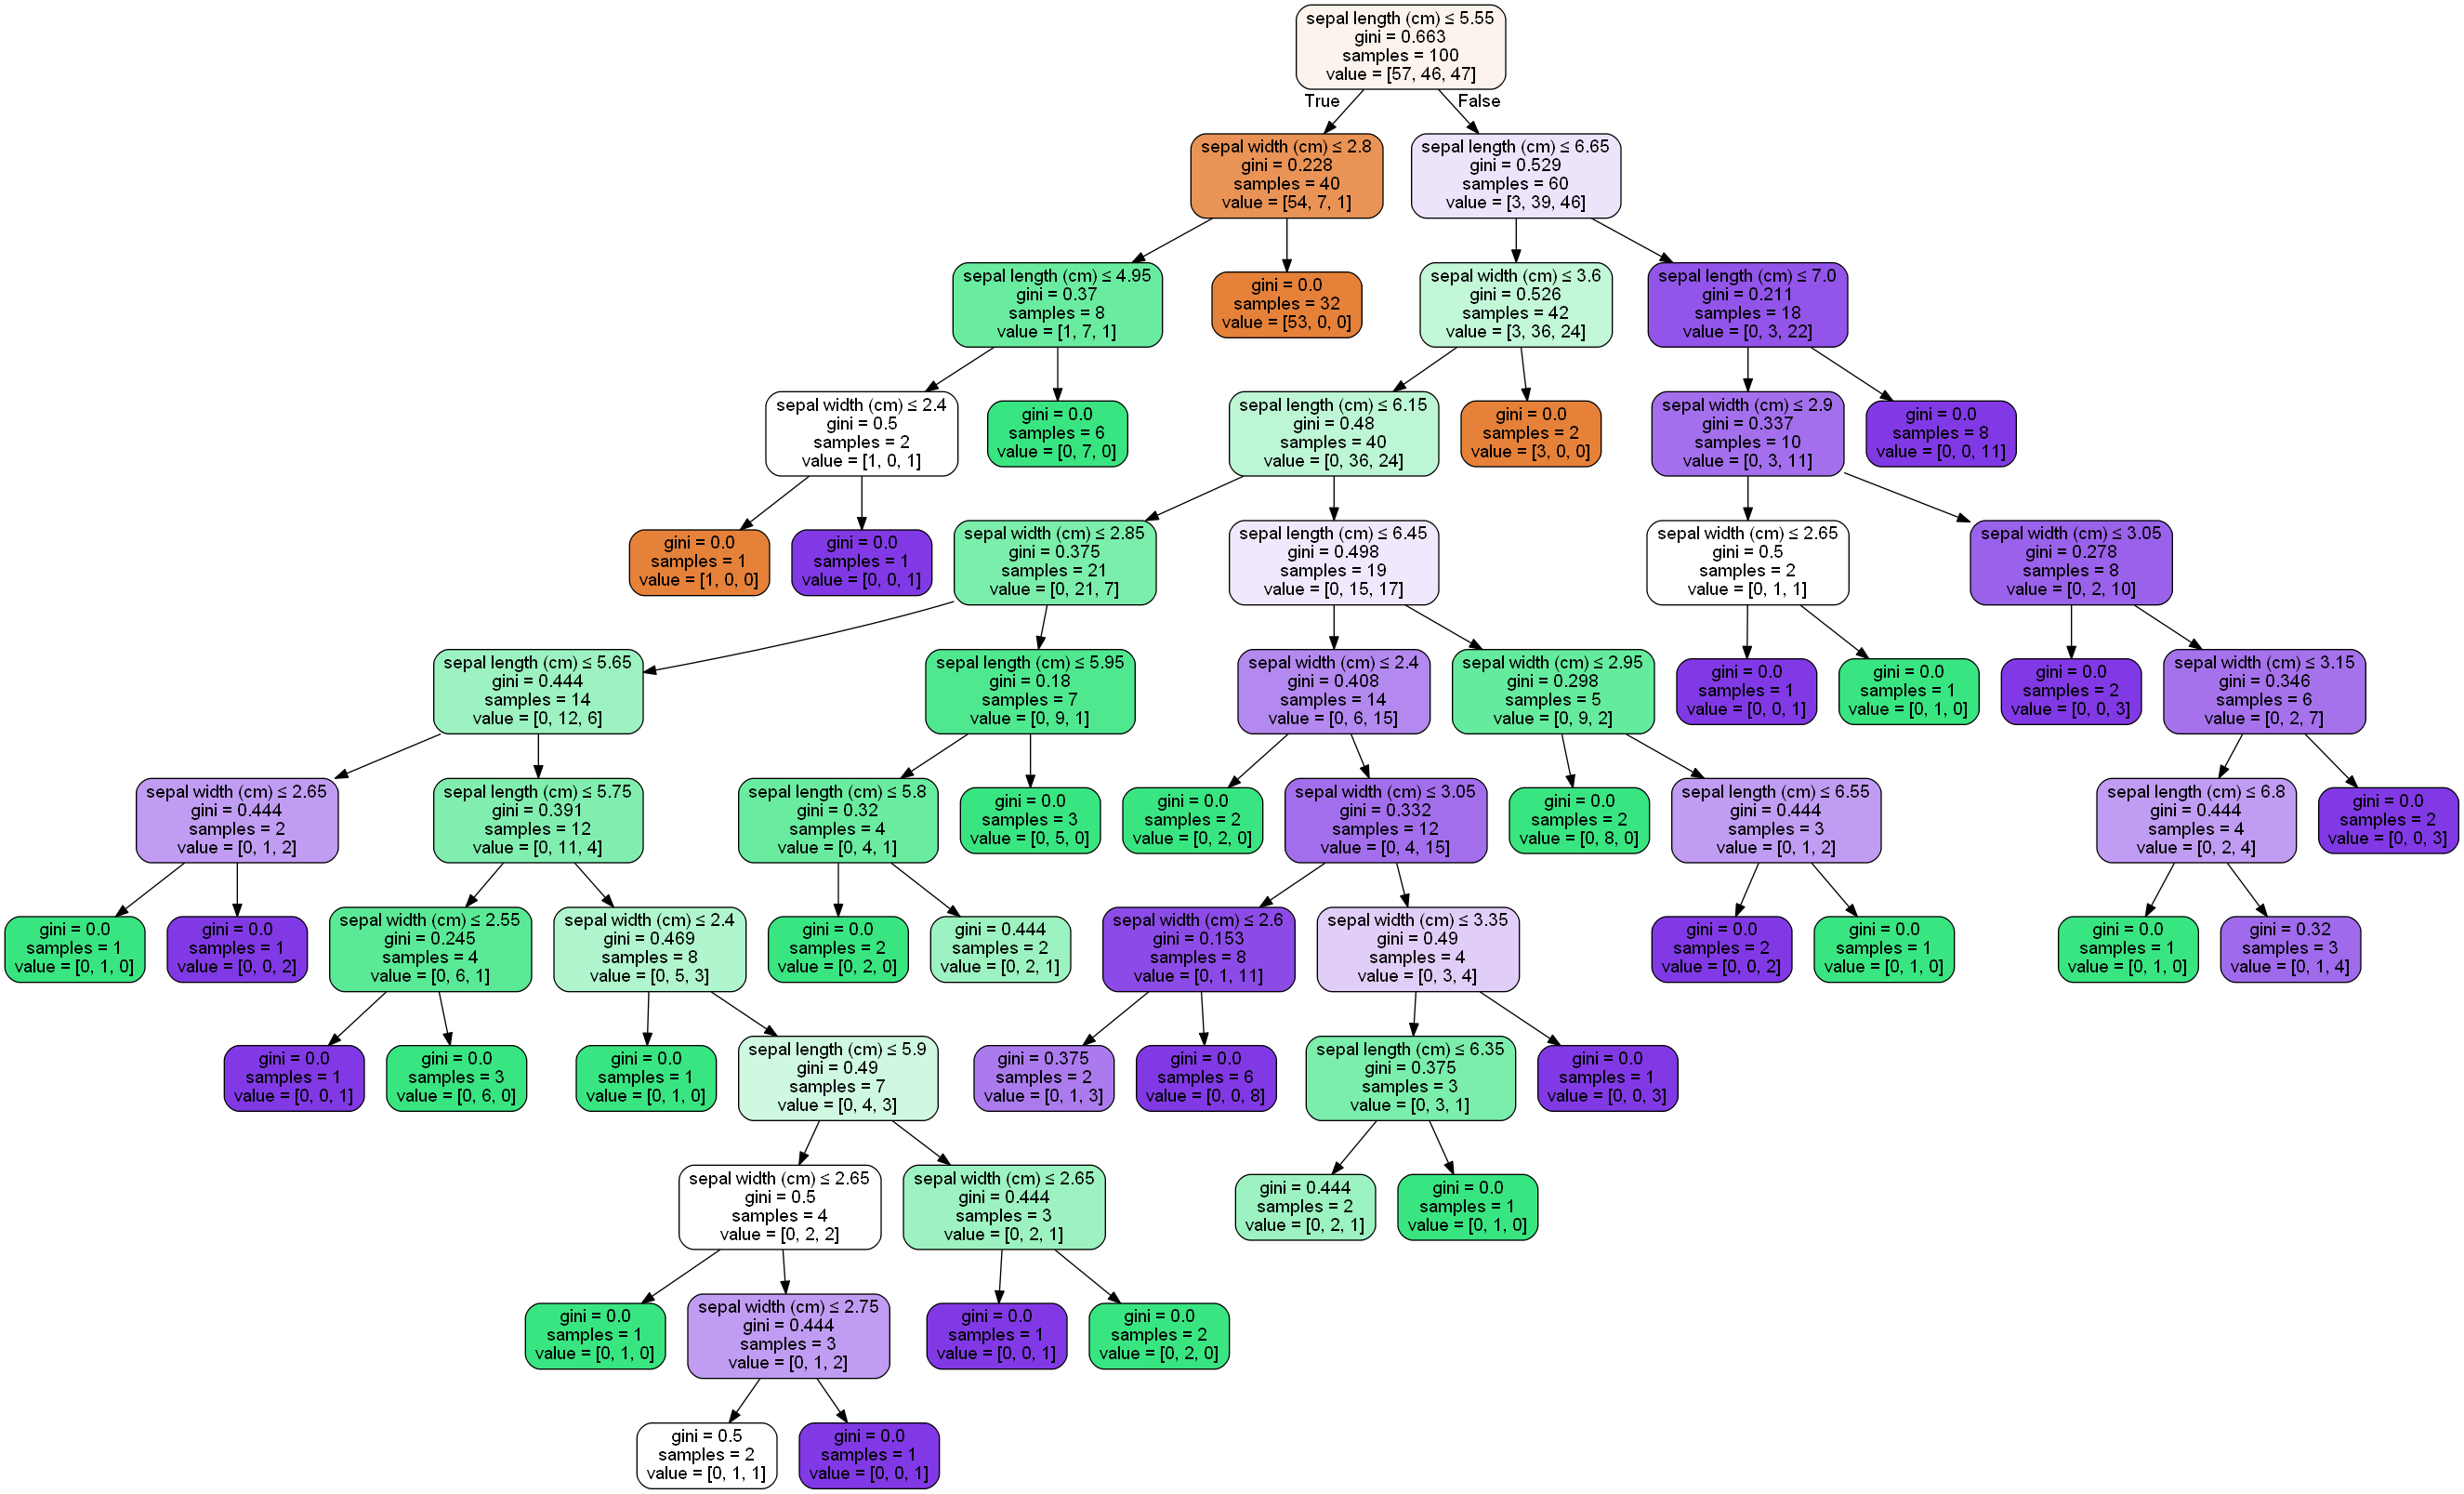

In [19]:
Image(get_png_tree(bc1.estimators_[2], iris.feature_names[:2]), width='80%')

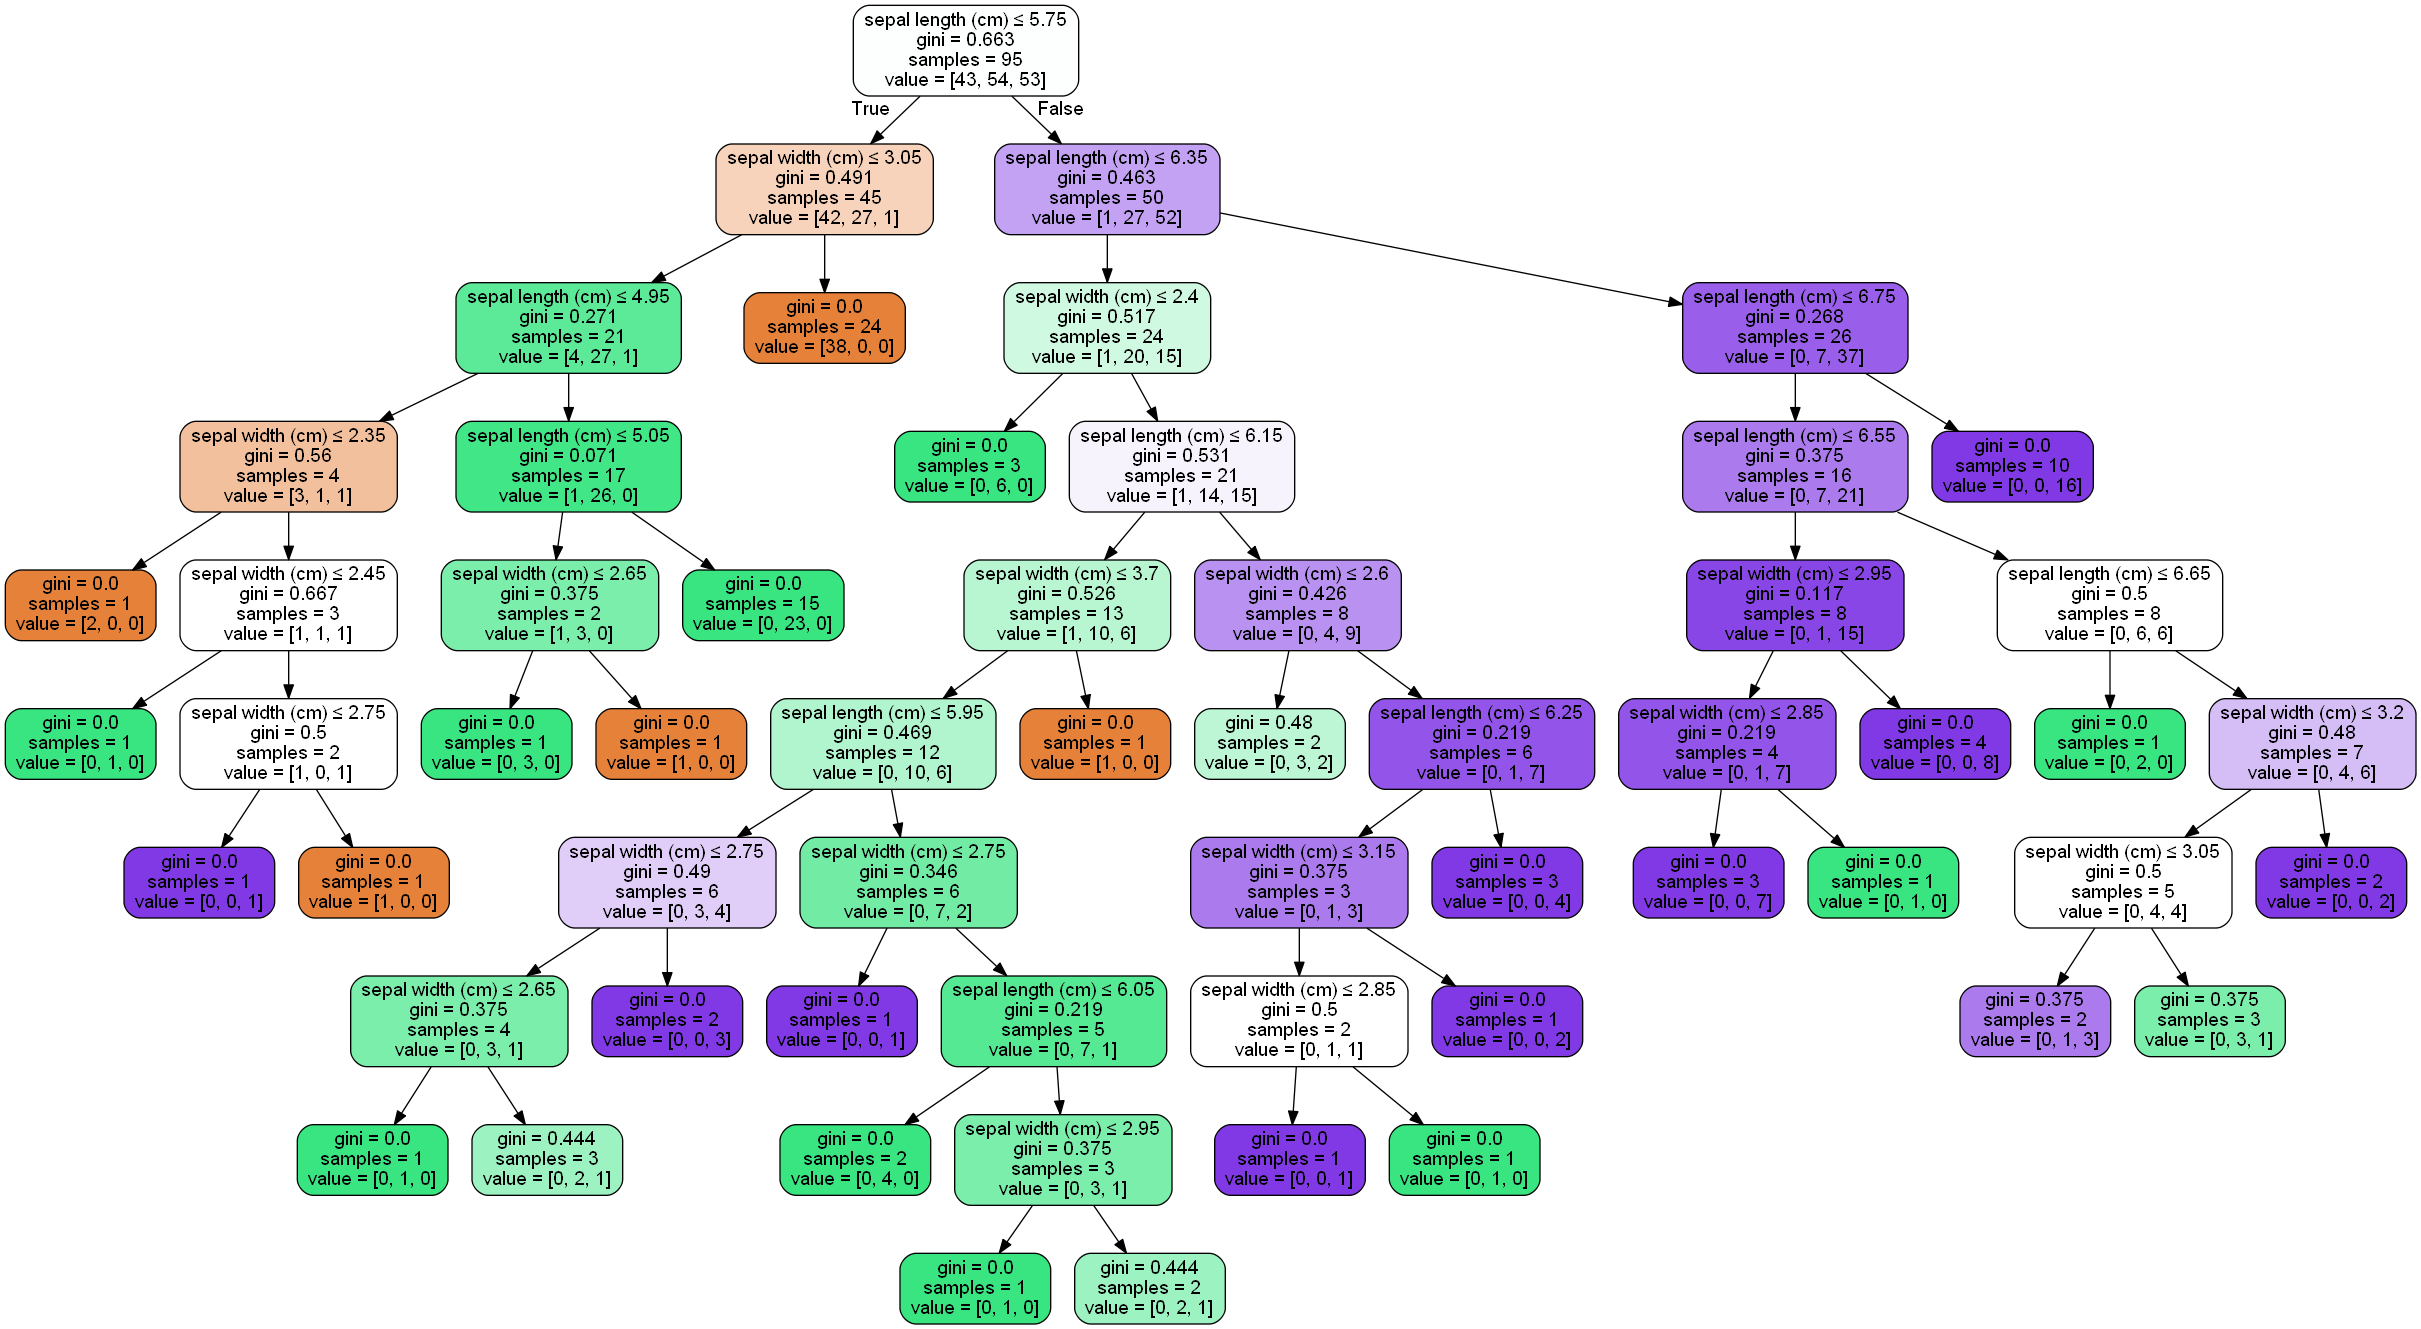

In [20]:
Image(get_png_tree(bc1.estimators_[3], iris.feature_names[:2]), width='80%')

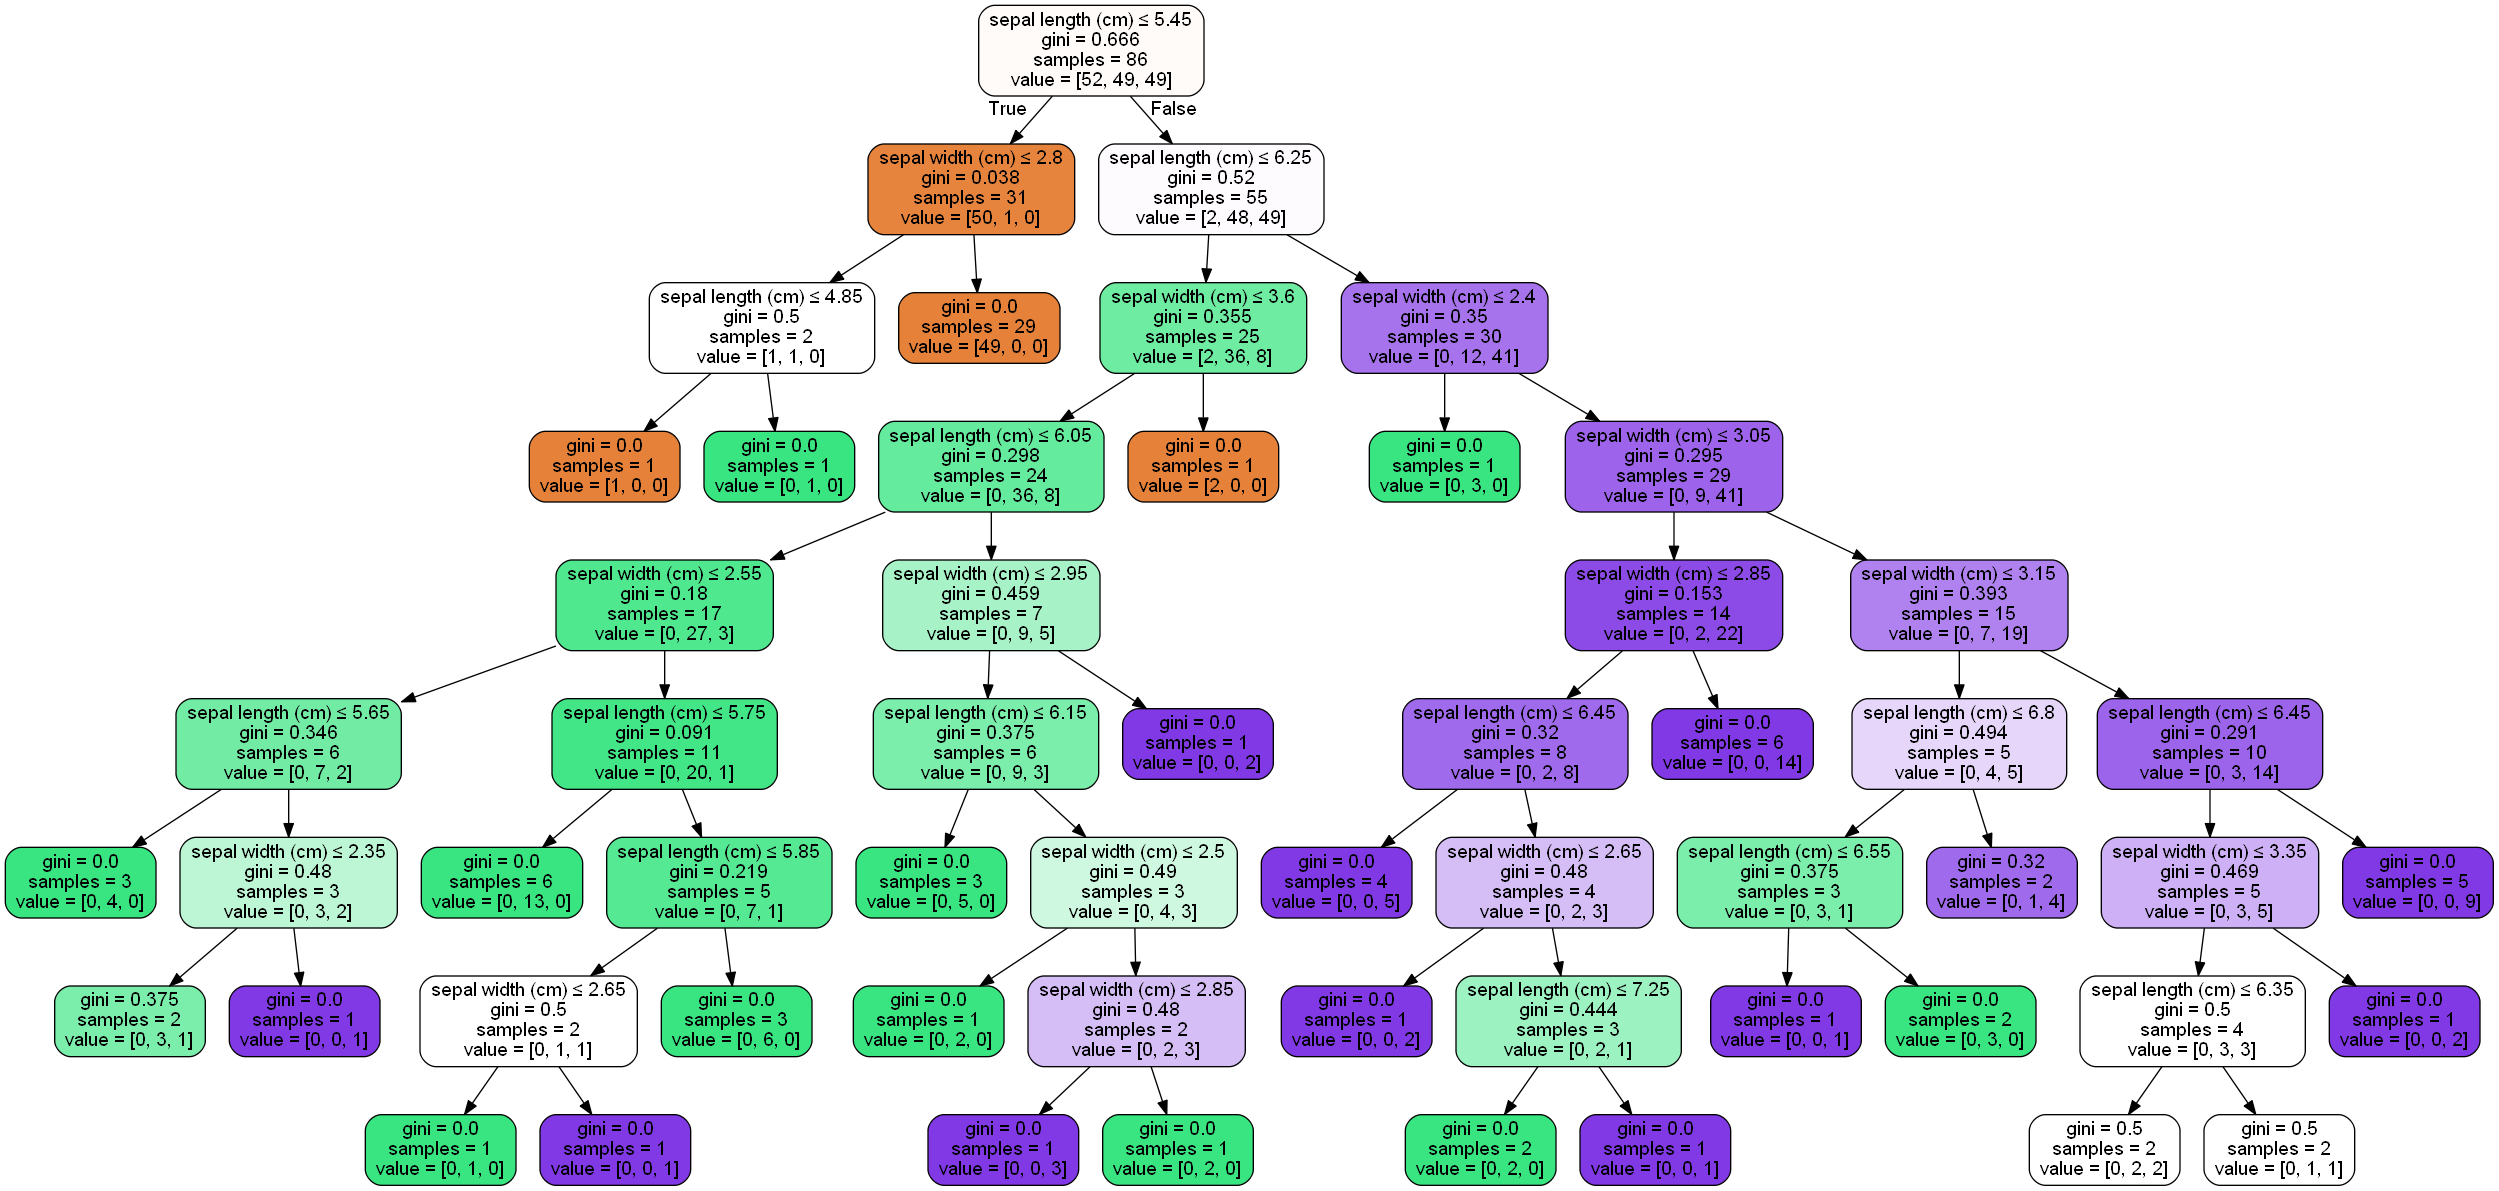

In [21]:
Image(get_png_tree(bc1.estimators_[4], iris.feature_names[:2]), width='80%')

Можно отметить, что деревья получаются различными. Таким образом, каждое дерево работает как "слабая модель".

#### Визуализация результатов классификации

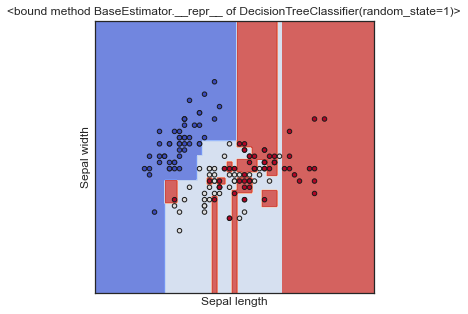

In [22]:
plot_cl(DecisionTreeClassifier(random_state=1))

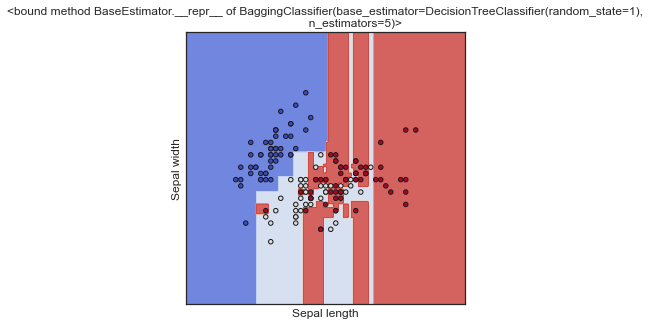

In [23]:
plot_cl(BaggingClassifier(DecisionTreeClassifier(random_state=1), n_estimators=5))

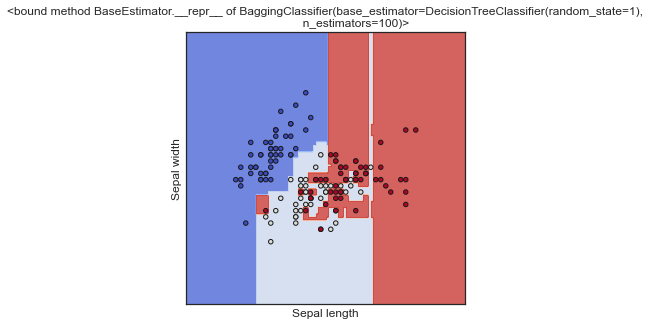

In [24]:
plot_cl(BaggingClassifier(DecisionTreeClassifier(random_state=1), n_estimators=100))

## [Случайный лес](https://ru.wikipedia.org/wiki/Random_forest)

Алгоритм случайного леса также предложен Лео Брейманом. Алгоритм сочетает в себе две основные идеи: метод бэггинга, предложенный Лео Брейманом, и метод случайных подпространств, предложенный Tin Kam Ho. 

Случайный лес можно рассматривать как алгоритмом бэггинга над решающими деревьями. 

Но при этом каждое решающее дерево строится на случайно выбранном подмножестве признаков. Эта особенность называется "feature bagging" и основана на [методе случайных подпространств](https://en.wikipedia.org/wiki/Random_subspace_method).

Метод случайных подпространств позволяет снизить коррелированность между деревьями и избежать переобучения. Базовые алгоритмы обучаются на случайно выбранных подмножествах признаков. Ансамбль моделей, использующих метод случайного подпространства, можно построить, используя следующий алгоритм:

1. Пусть количество объектов для обучения равно $N$, а количество признаков $D$.
1. Выбирается число отдельных моделей в ансамбле $L$.
1. Для каждой отдельной модели $l = 1..L$ выбирается число признаков $dl (dl < D)$. Как правило, для всех моделей используется только одно значение
$dl$.
1. Для каждой отдельной модели $l$ создается обучающая выборка путем отбора $dl$ признаков из $D$.
1. Производится обучение моделей $l = 1..L$, каждая модель обучается на отдельном подмножестве из $dl$ признаков.
1. Чтобы применить модель ансамбля к тестовой выборке, объединяются результаты отдельных моделей или мажоритарным голосованием или более сложными способами.

Почему именно деревья активно используются в ансамблевых моделях? Потому что они очень чувствительны к выбросам и изменению данных. Незначительное изменение обучающей выборки, удаление или добавление признаков может сильно изменить вид решающего дерева. Это является недостатком с точки зрения построения отдельного решающего дерева. Это же является преимуществом при использовании деревьев в ансамблевой модели, так как с помощью незначительного изменения обучающих данных или набора используемых признаков можно построить очень разные решающие деревья. Различные решающие деревья дадут хорошую "дисперсию" решений при объединении их в ансамбль.

### Принцип построения случайного леса:

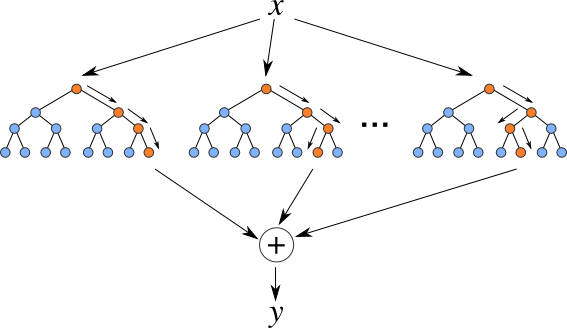

In [25]:
Image("img/rf.png")

### Алгоритм построения случайного леса

- Пусть количество объектов для обучения равно $N$, а количество признаков $D$.
- Выбирается число отдельных деревьев в ансамбле (случайном лесе) $L$. Для каждого отдельного дерева $tree_i = 1..L$ выбирается число признаков $dl (dl < D)$ для последующего случайного разбиения. Как правило, для всех моделей используется только одно значение $dl$.
- Для каждого дерева с индексом $i=1..L$ выполняются следующие действия:
    - Генерируется выборка $X_i$ с помощью бутстрэпа
    - При построении решающего дерева $tree_i$ по выборке $X_i$:
        - По заданному критерию выбирается лучший признак для ветвления дерева, делается ветвление в дереве по выбранному признаку и так до исчерпания выборки. В качестве критерия может использоваться критерий Джини или энтропийный критерий.
        - Дерево строится до тех пор, пока в каждом листе не более $leaf_{min}$ объектов или пока не будет достигнута определенная высота дерева.
        - При каждом разбиении сначала выбирается $dl$ случайных признаков из $D$ исходных, и оптимальное разделение выборки ищется только среди них.

- Итоговая модель $RandomForest(X) = \frac{1}{L} \sum\limits_{i=1}^L tree_i(X)$. То есть для задачи кассификации выбирается решение голосованием по большинству, а в задаче регрессии — среднее значение.

Таким образом, случайный лес — это бэггинг над решающими деревьями, при обучении которых для каждого разбиения признаки выбираются из некоторого случайного подмножества признаков.

Рекомендуется в задачах классификации брать $dl=\sqrt{D}$, а в задачах регрессии $dl = D/3$. В библиотеке scikit-learn это признак max_features.

Для выбора параметра $leaf_{min}$ рекомендуется в задачах классификации строить каждое дерево до тех пор, пока в каждом листе не окажется по одному объекту, а в задачах регрессии — пока в каждом листе не окажется по пять объектов. В библиотеке scikit-learn это признак min_samples_leaf.

Настройка гиперпараметров случайного леса хорошо описана в [блоге Александра Дьяконова.](https://dyakonov.org/2016/11/14/%D1%81%D0%BB%D1%83%D1%87%D0%B0%D0%B9%D0%BD%D1%8B%D0%B9-%D0%BB%D0%B5%D1%81-random-forest/comment-page-1/)

Алгоритм случайного леса активно применяется на практике и часто оказывается лучшим при сравнении метрик качества.

Случайный лес реализуется в scikit-learn с помощью классов [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) и [RandomForestRegressor.](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) Задание параметра n_jobs=-1 распараллеливает алгоритм на максимально возможное количество процессоров. 

### Сверхслучайные деревья

В сверхслучайных деревьях (Extremely Randomized Trees) больше случайности в том, как вычисляются разделения в узлах. Как и в случайных лесах, используется случайное подмножество возможных признаков, но вместо поиска  оптимальных порогов, пороговые значения произвольно выбираются для каждого возможного признака, и наилучший из этих случайно генерируемых порогов выбирается как лучшее правило для разделения узла. Это обычно позволяет немного уменьшить дисперсию модели за счет несколько большего увеличения смещения.

Данный метод следует использовать при сильном переобучении на случайном лесе или градиентном бустинге. 

Сверхслучайные деревья реализуется в scikit-learn с помощью классов  [ExtraTreesClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html#sklearn.ensemble.ExtraTreesClassifier) и [ExtraTreesRegressor.](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html#sklearn.ensemble.ExtraTreesRegressor) 

### Эксперименты

In [26]:
# Обучим классификатор на 5 деревьях
tree1 = RandomForestClassifier(n_estimators=5, oob_score=True, random_state=10)
tree1.fit(iris_X, iris_y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /


RandomForestClassifier(n_estimators=5, oob_score=True, random_state=10)

In [27]:
# Out-of-bag error, возвращаемый классификатором
tree1.oob_score_, 1-tree1.oob_score_

(0.6666666666666666, 0.33333333333333337)

In [28]:
tree1.oob_decision_function_[55:70]

array([[0.        , 1.        , 0.        ],
       [0.        , 0.        , 1.        ],
       [0.33333333, 0.33333333, 0.33333333],
       [0.        , 1.        , 0.        ],
       [0.        , 0.8       , 0.2       ],
       [0.33333333, 0.66666667, 0.        ],
       [0.        , 0.        , 1.        ],
       [       nan,        nan,        nan],
       [0.        , 0.5       , 0.5       ],
       [0.        , 1.        , 0.        ],
       [0.        , 0.91666667, 0.08333333],
       [0.        , 1.        , 0.        ],
       [0.        , 0.25      , 0.75      ],
       [       nan,        nan,        nan],
       [0.        , 1.        , 0.        ]])

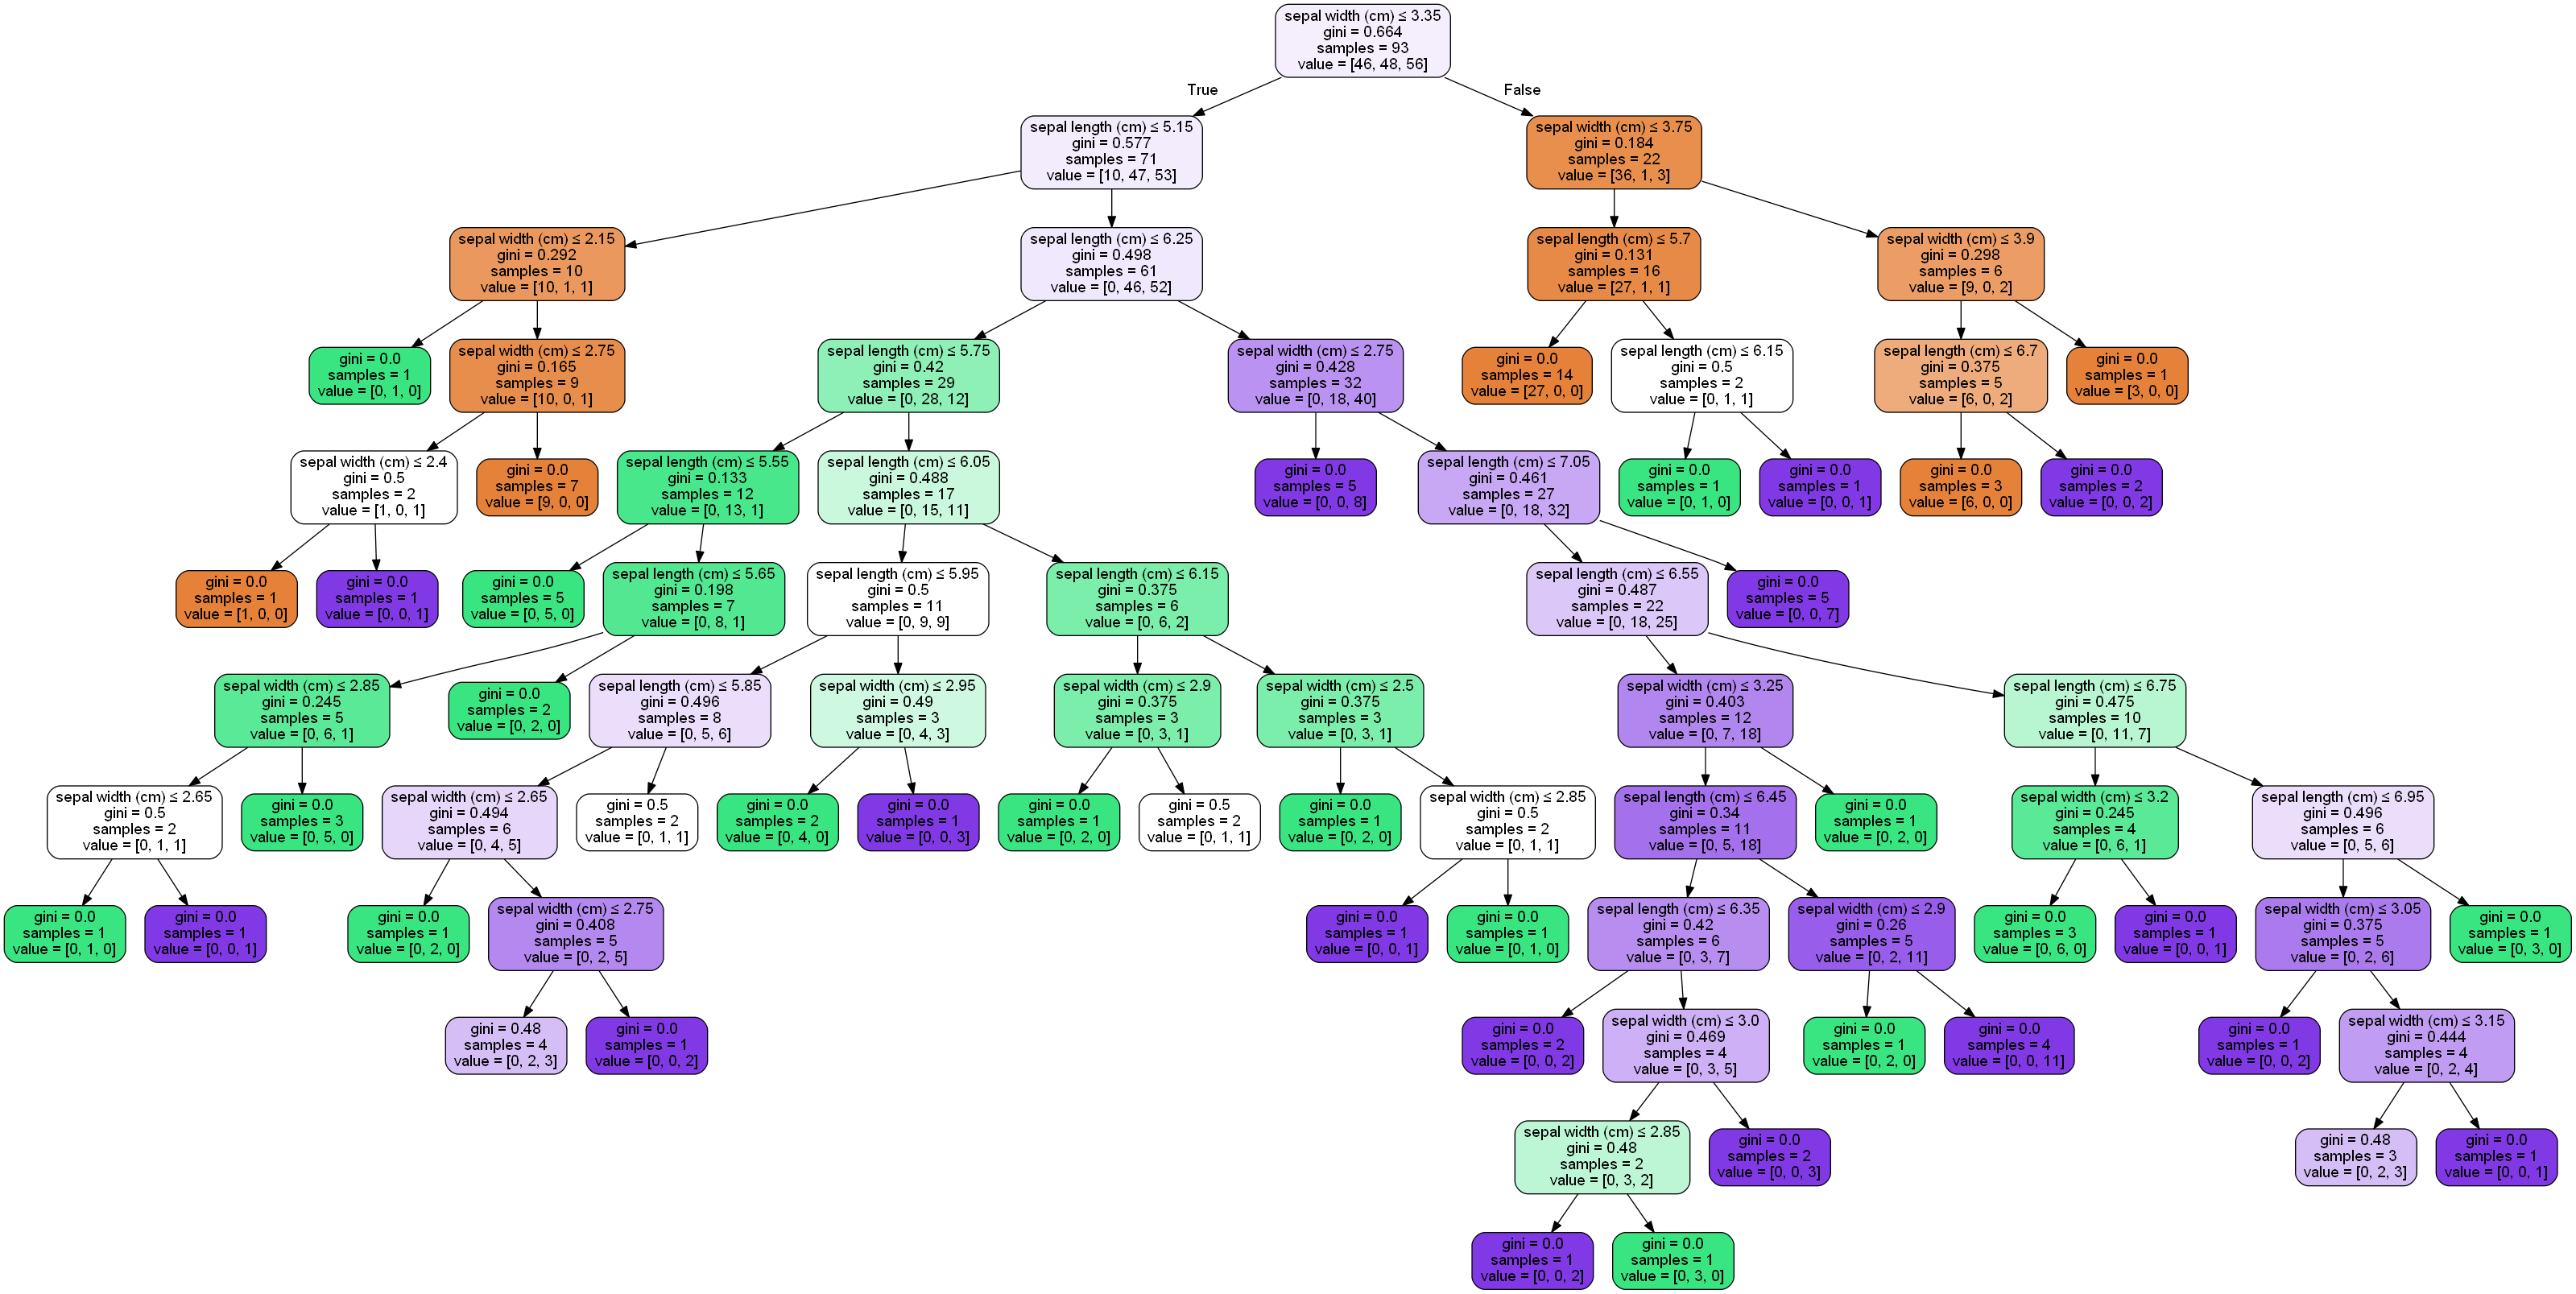

In [29]:
Image(get_png_tree(tree1.estimators_[0], iris.feature_names[:2]), width="500")

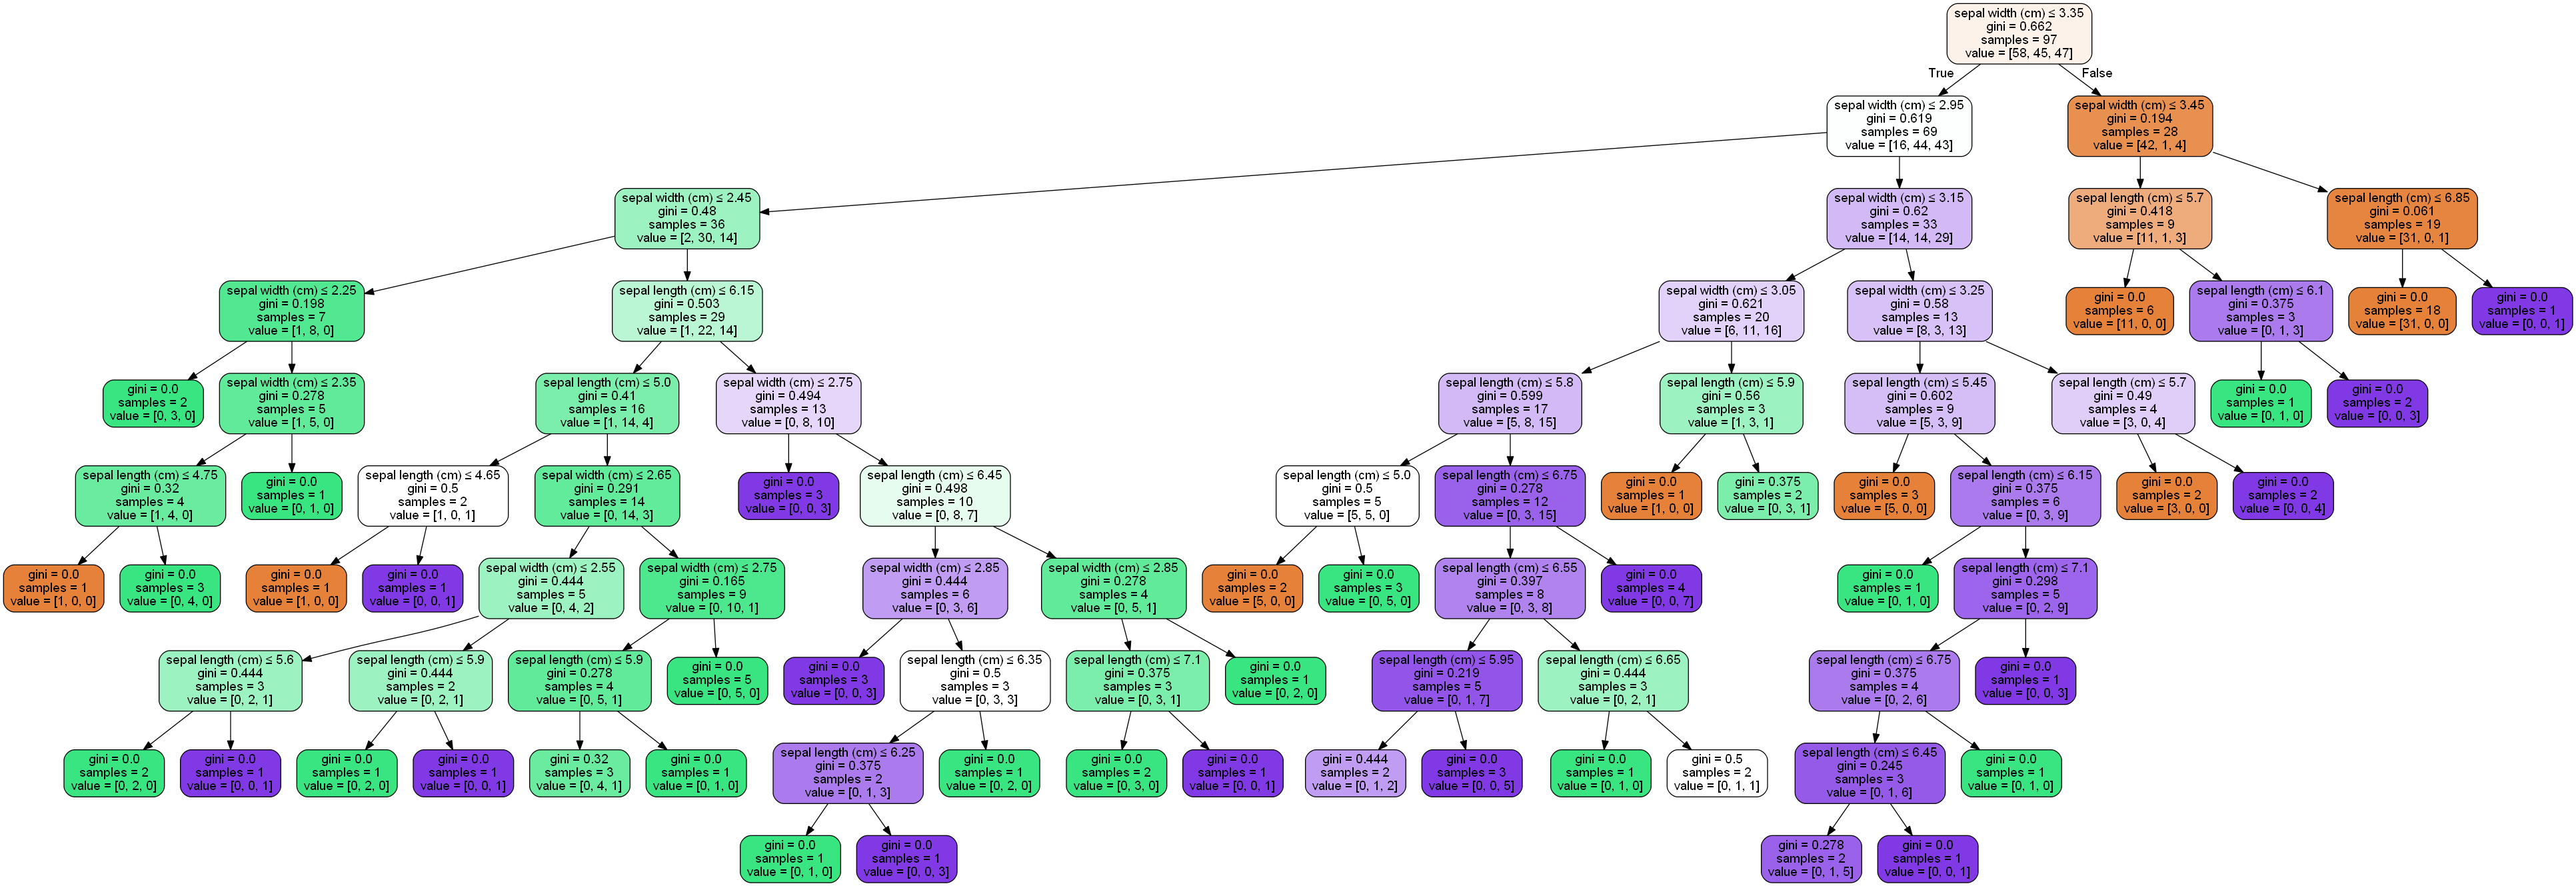

In [30]:
Image(get_png_tree(tree1.estimators_[1], iris.feature_names[:2]), width="500")

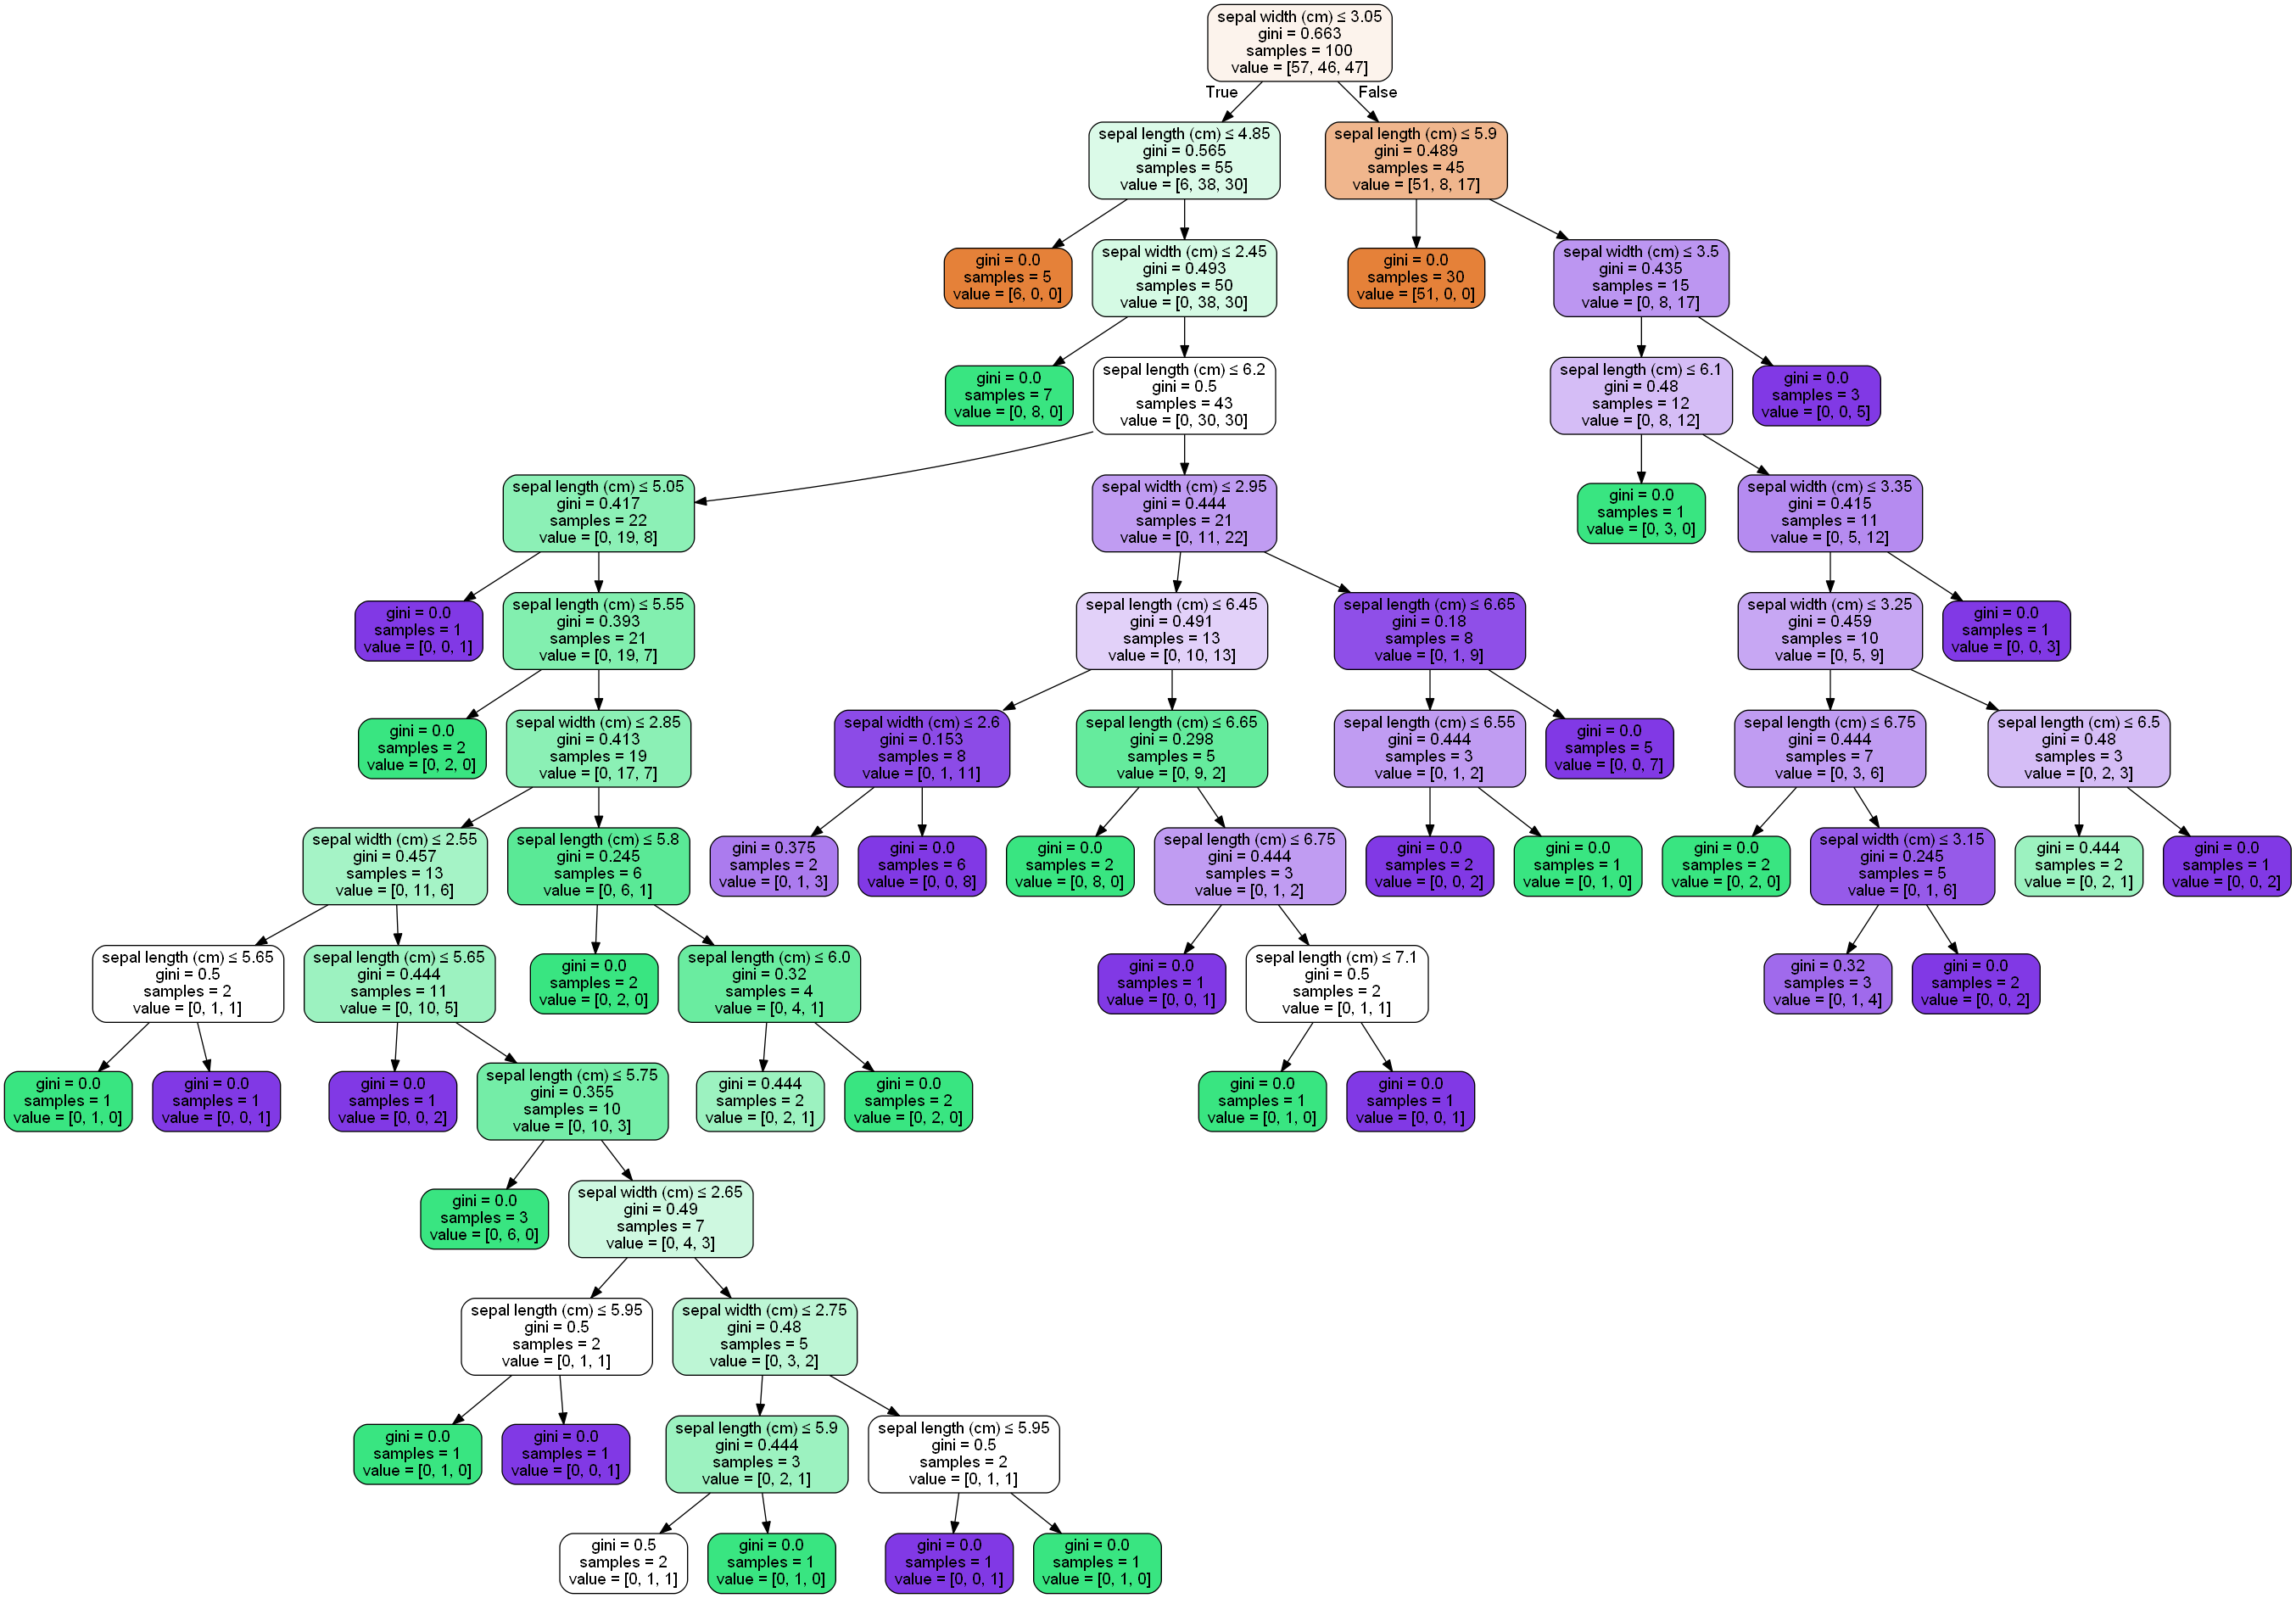

In [31]:
Image(get_png_tree(tree1.estimators_[2], iris.feature_names[:2]), width="500")

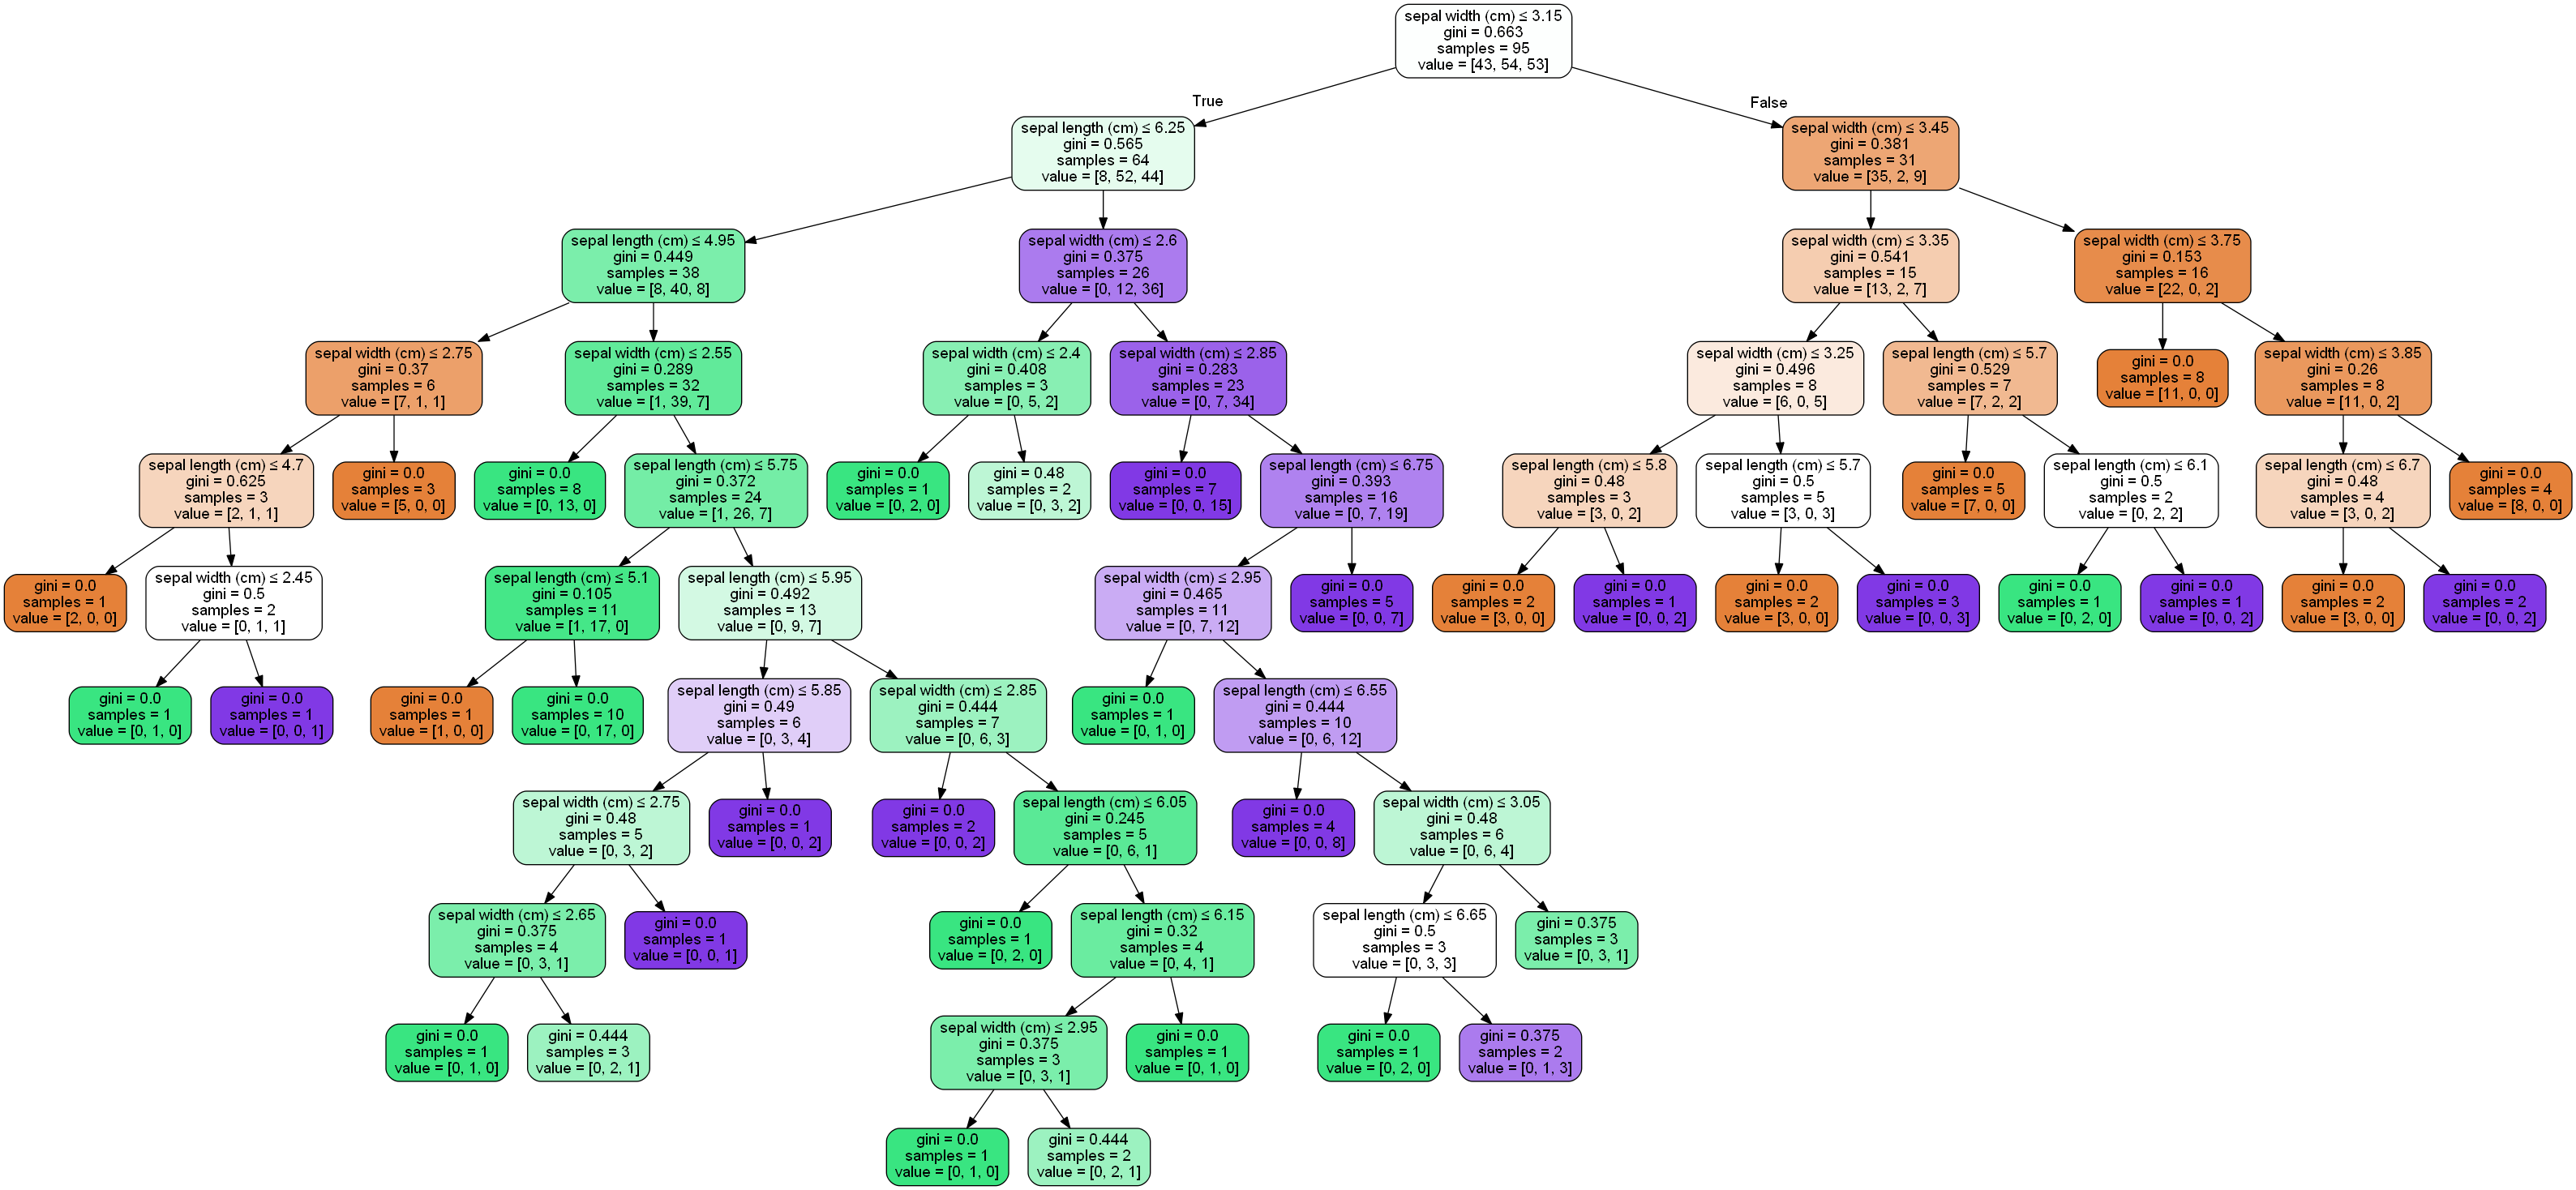

In [32]:
Image(get_png_tree(tree1.estimators_[3], iris.feature_names[:2]), width="500")

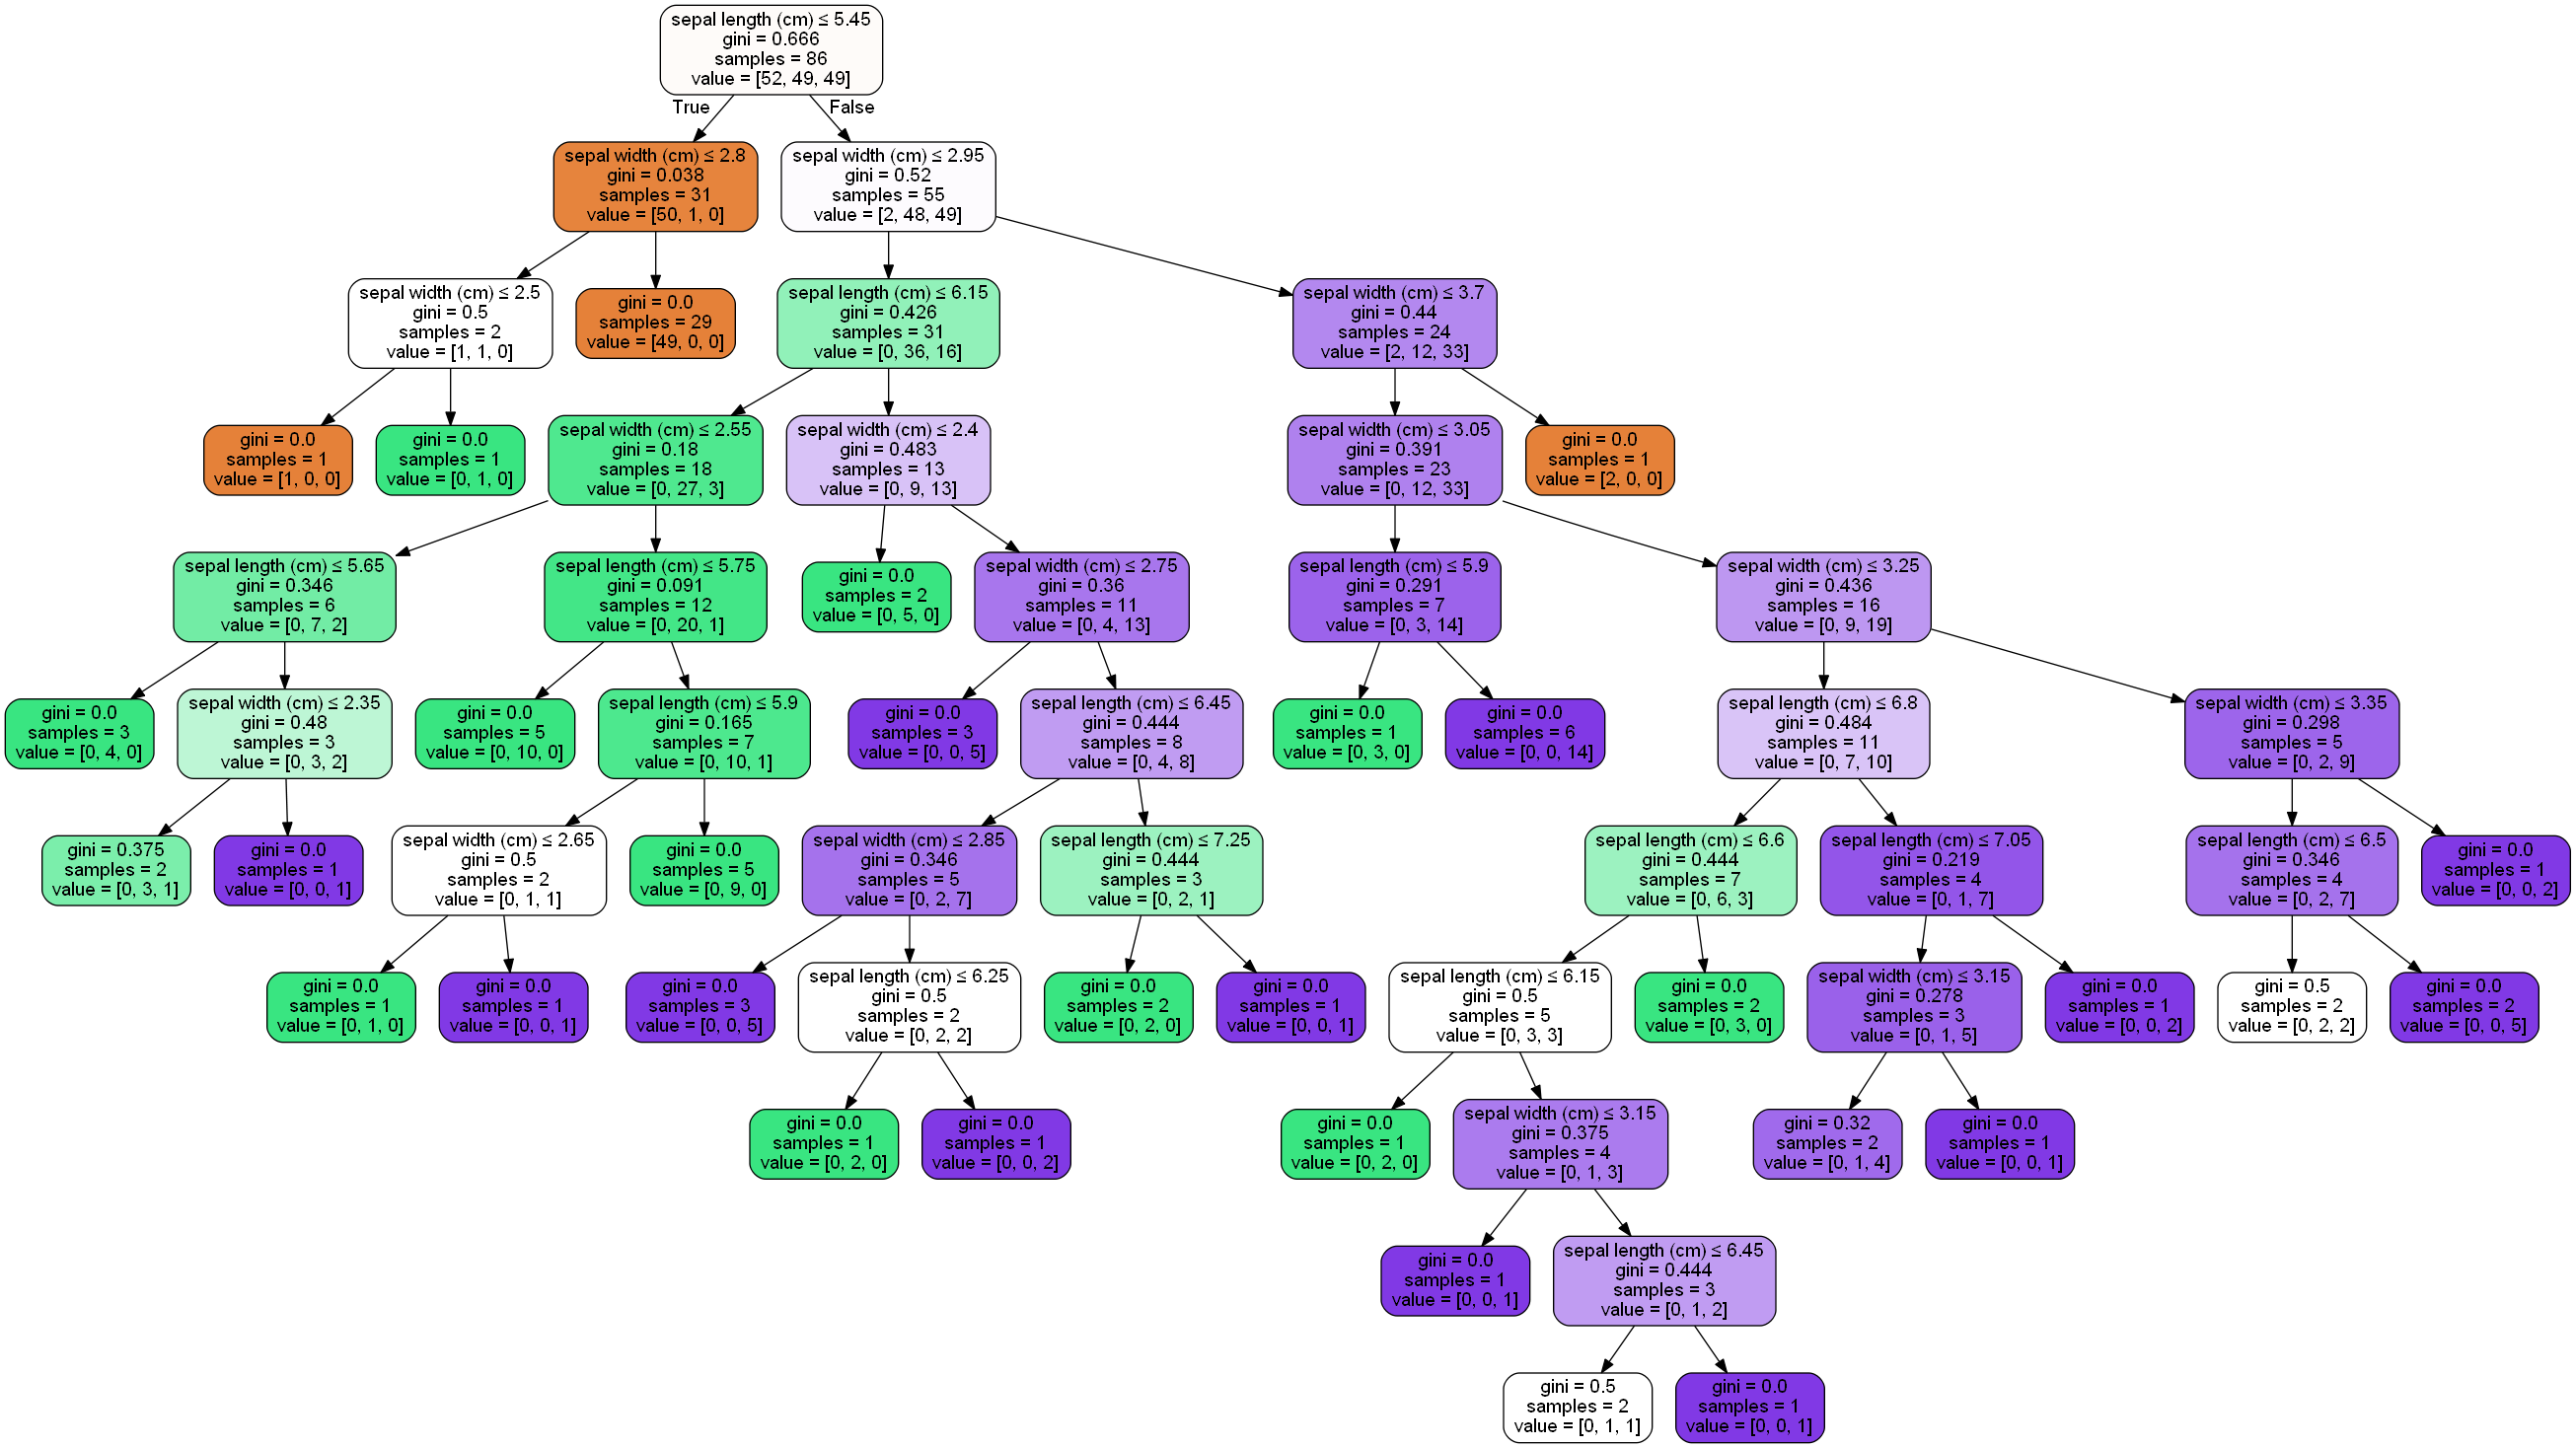

In [33]:
Image(get_png_tree(tree1.estimators_[4], iris.feature_names[:2]), width="500")

Можно отметить, что в случае случайного леса деревья получаются более разнообразными, чем в случае бэггинга.

### Визуализация результатов классификации

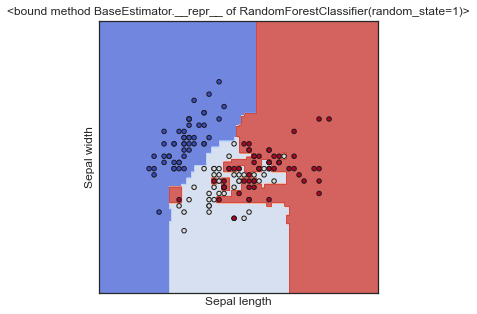

In [34]:
plot_cl(RandomForestClassifier(random_state=1))

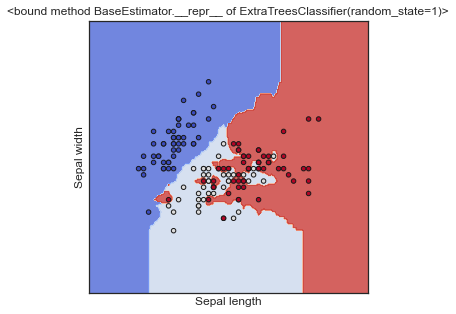

In [35]:
plot_cl(ExtraTreesClassifier(random_state=1))

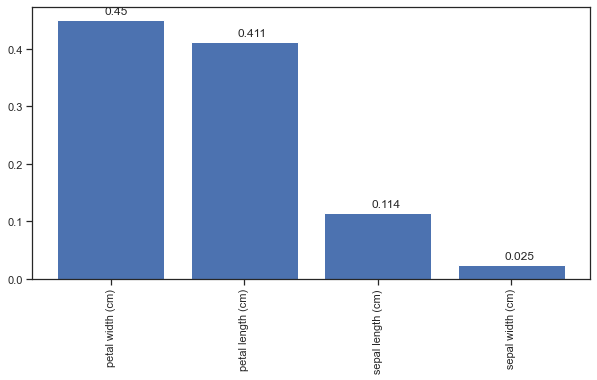

In [36]:
# Важность признаков
iris_x_ds = pd.DataFrame(data=iris['data'], columns=iris['feature_names'])
iris_rf_cl = RandomForestClassifier(random_state=1)
iris_rf_cl.fit(iris_x_ds, iris.target)
_,_ = draw_feature_importances(iris_rf_cl, iris_x_ds)

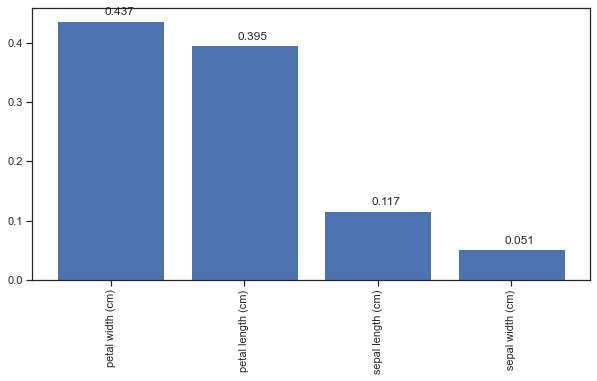

In [37]:
iris_xtree_cl = ExtraTreesClassifier(random_state=1)
iris_xtree_cl.fit(iris_x_ds, iris.target)
_, _ = draw_feature_importances(iris_xtree_cl, iris_x_ds)

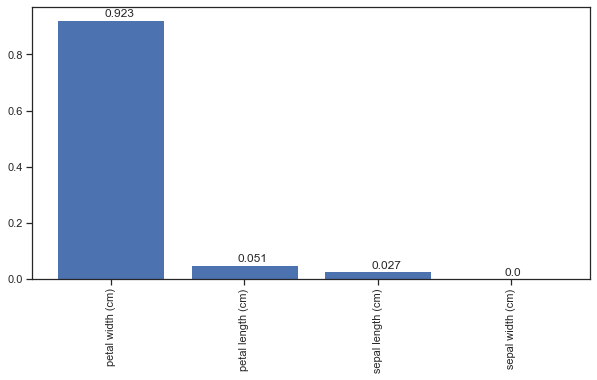

In [38]:
iris_tree_cl = DecisionTreeClassifier(random_state=1)
iris_tree_cl.fit(iris_x_ds, iris.target)
_,_ = draw_feature_importances(iris_tree_cl, iris_x_ds)

## [Бустинг](https://ru.wikipedia.org/wiki/%D0%91%D1%83%D1%81%D1%82%D0%B8%D0%BD%D0%B3_(%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D0%B5_%D0%BC%D0%B0%D1%88%D0%B8%D0%BD))

Изначально метод бустинга (от hypothesis boosting - усиление гипотезы) - это любой ансамблевый метод, который способен комбинировать несколько "слабых моделей" в одну "сильную модель". 

Сейчас термин "бустинг", как правило, ассоциируется с алгоритмом градиентного бустинга.

В отличие от методов бэггинга и случайного леса, которые **ориентированы прежде всего на минимизизацию дисперсии (Variance)**, методы бустинга **ориентированы прежде всего на минимизацию смещения (Bias) и, отчасти, на минимизизацию дисперсии.**

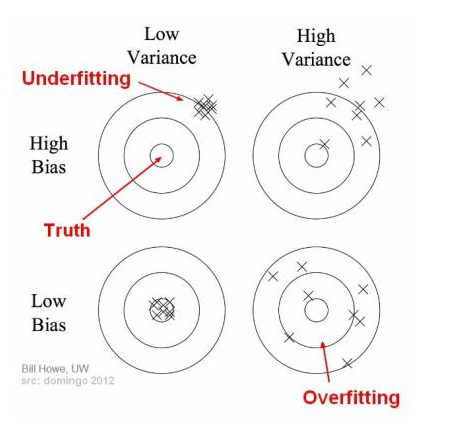

In [39]:
Image('img/bv1.png', width='30%')

Идея метода отчасти напоминает идею нейронной сети, но в качестве "нейрона" обычно используется решающее дерево (хотя может использоваться произвольная модель).

Различие между бэггингом и бустингом показано на следющем рисунке:

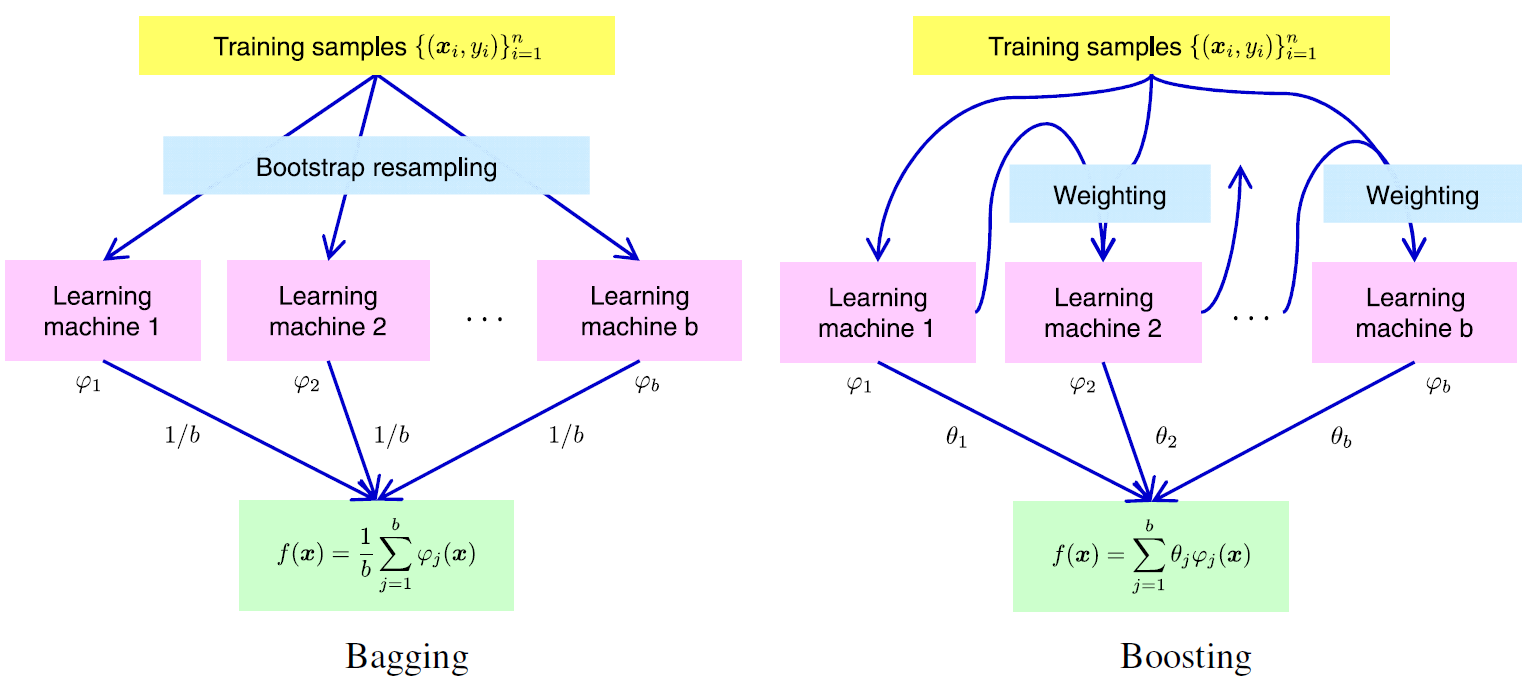

In [40]:
Image('img/boosting.png', width='55%')

**Бустинг может рассматриваться как разновидность линейной регресии, где регрессорами являются выходы "слабых моделей".**

### Алгоритм AdaBoost

Исторически первым полноценным алгоритмом бустинга считается алгоритм [AdaBoost.](https://ru.wikipedia.org/wiki/AdaBoost) 

[Статья авторов с пояснением метода.](http://www.site.uottawa.ca/~stan/csi5387/boost-tut-ppr.pdf)

[Презентация 1](https://mycourses.aalto.fi/pluginfile.php/901916/mod_folder/content/0/Boosting.pdf) и [Презентация 2](http://cmp.felk.cvut.cz/~sochmj1/adaboost_talk.pdf) с пояснением работы метода ([локальная копия презентации 1](materials/boosting.pdf)). 

AdaBoost реализуется в scikit-learn с помощью классов [AdaBoostClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html) и [AdaBoostRegressor.](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html)

В библиотеке scikit-learn реализован многоклассовый вариант алгоритма AdaBoost - [алгоритм SAMME.](https://web.stanford.edu/~hastie/Papers/samme.pdf) (Stagewise Additive Modeling using a Multiclass Exponential loss function - ступенчатое аддитивное моделирование с применением многоклассовой экспоненциальной функции потерь). Модификация этого алгоритма, которая предсказывает не только классы, но и вероятности классов называется "SAMME.R".

#### Эксперименты с реализацией scikit-learn:

In [41]:
# Обучим классификатор на 5 деревьях
ab1 = AdaBoostClassifier(n_estimators=5, algorithm='SAMME', random_state=10)
ab1.fit(iris_X, iris_y)

AdaBoostClassifier(algorithm='SAMME', n_estimators=5, random_state=10)

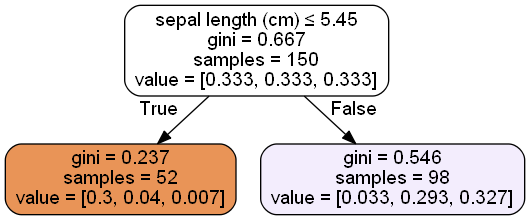

In [42]:
Image(get_png_tree(ab1.estimators_[0], iris.feature_names[:2]), width='40%')

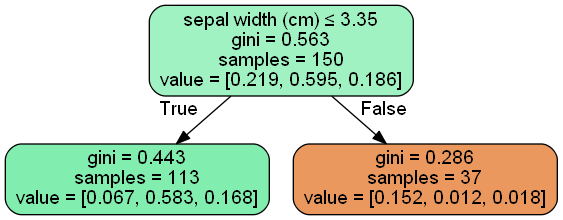

In [43]:
Image(get_png_tree(ab1.estimators_[1], iris.feature_names[:2]), width='40%')

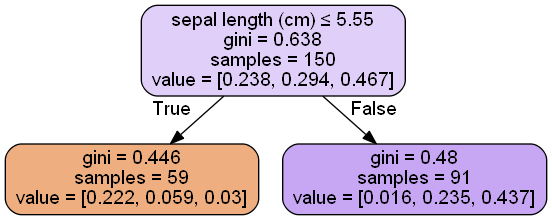

In [44]:
Image(get_png_tree(ab1.estimators_[2], iris.feature_names[:2]), width='40%')

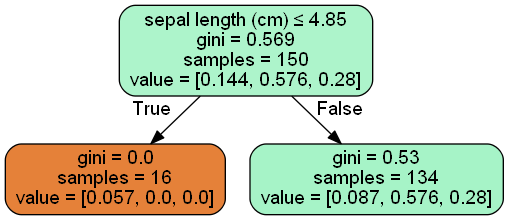

In [45]:
Image(get_png_tree(ab1.estimators_[3], iris.feature_names[:2]), width='40%')

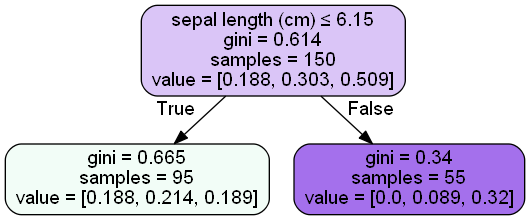

In [46]:
Image(get_png_tree(ab1.estimators_[4], iris.feature_names[:2]), width='40%')

Веса деревьев в ансамбле соответствуют параметру $\alpha_t$:

In [47]:
ab1.estimator_weights_

array([1.21109027, 1.71357397, 1.35360531, 1.24138009, 0.83110679])

Метод decision_function(X) возвращает итоговое значение матрицы $D_t$:

In [48]:
df1 = ab1.decision_function(iris_X)
df1.shape

(150, 3)

In [49]:
df1[:10]

array([[0.67366299, 0.32633701, 0.        ],
       [0.40384096, 0.59615904, 0.        ],
       [0.5993106 , 0.4006894 , 0.        ],
       [0.5993106 , 0.4006894 , 0.        ],
       [0.67366299, 0.32633701, 0.        ],
       [0.67366299, 0.32633701, 0.        ],
       [0.86913263, 0.13086737, 0.        ],
       [0.67366299, 0.32633701, 0.        ],
       [0.5993106 , 0.4006894 , 0.        ],
       [0.40384096, 0.59615904, 0.        ]])

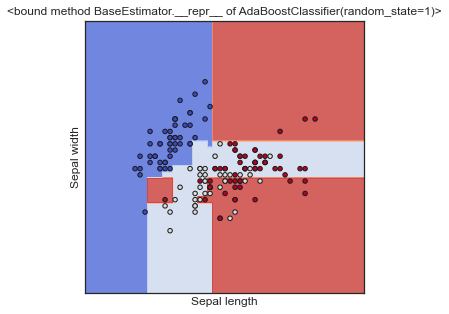

In [50]:
# Результаты классификации
plot_cl(AdaBoostClassifier(random_state=1))

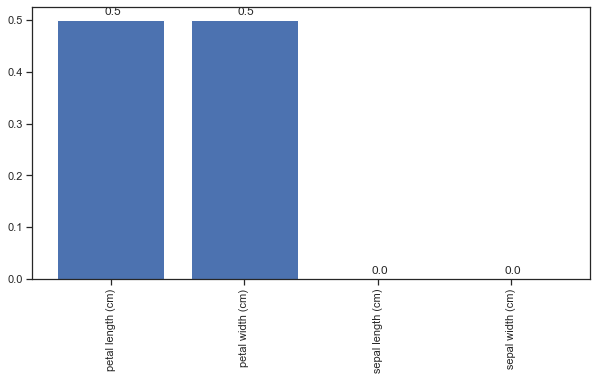

In [51]:
# Важность признаков
ab2 = AdaBoostClassifier(random_state=1)
ab2.fit(iris_x_ds, iris.target)
_,_ = draw_feature_importances(ab2, iris_x_ds)

В настоящее время алгоритм AdaBoost считается устаревшим и вместо него используется:

### Алгоритм [градиентного бустинга](https://en.wikipedia.org/wiki/Gradient_boosting)

Идея градиентного бустинга состоит в том, что строится многослойная модель (классификации или регрессии) и каждый следующий слой пытается минимизировать остаточную ошибку (residual error), допущенную на предыдущем слое.

[Краткое введение в градиентный бустинг.](https://neurohive.io/ru/osnovy-data-science/gradientyj-busting/)

[Блог Александра Дьяконова. Градиентный бустинг](https://dyakonov.org/2017/06/09/%d0%b3%d1%80%d0%b0%d0%b4%d0%b8%d0%b5%d0%bd%d1%82%d0%bd%d1%8b%d0%b9-%d0%b1%d1%83%d1%81%d1%82%d0%b8%d0%bd%d0%b3/)

Основные принципы градиентного бустинга изложены в [математическом описании реализации scikit-learn.](https://scikit-learn.org/stable/modules/ensemble.html#mathematical-formulation)

#### Реализации градиентного бустинга

Рассмотрены в статьях:
- https://medium.com/diogo-menezes-borges/boosting-with-adaboost-and-gradient-boosting-9cbab2a1af81
- https://towardsdatascience.com/catboost-vs-light-gbm-vs-xgboost-5f93620723db

Градиентный бустинг реализуется в scikit-learn с помощью классов [GradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) и [GradientBoostingRegressor.](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html) Но эта реализация считается неэффективной.

Традиционно вместо нее использовалась библиотека [XGBoost.](https://github.com/dmlc/xgboost)

В последнее время также активно используется библиотека [LightGBM.](https://github.com/Microsoft/LightGBM) Статья о [настройке гиперпараметров.](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html)

Наиболее новой и перспективной является библиотека от Яндекса [CatBoost.](https://tech.yandex.ru/catboost/)

#### Эксперименты с реализацией scikit-learn:

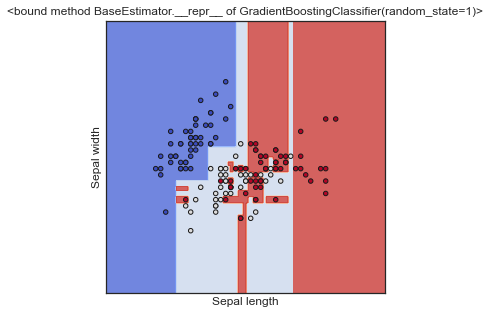

In [52]:
plot_cl(GradientBoostingClassifier(random_state=1))

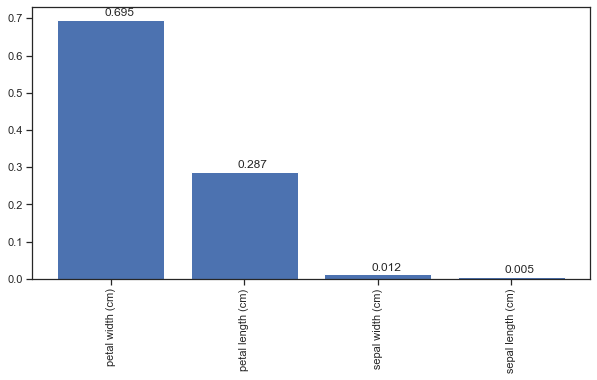

In [53]:
# Важность признаков
iris_gb_cl = GradientBoostingClassifier(random_state=1)
iris_gb_cl.fit(iris_x_ds, iris.target)
_,_ = draw_feature_importances(iris_gb_cl, iris_x_ds)

# Дополнительные источники
- [Открытый курс машинного обучения. Тема 5. Композиции: бэггинг, случайный лес](https://habr.com/ru/company/ods/blog/324402/)
- [Открытый курс машинного обучения. Тема 10. Градиентный бустинг](https://habr.com/ru/company/ods/blog/327250/)
- [Блог Александра Дьяконова. Ансамбли в машинном обучении](https://dyakonov.org/2019/04/19/%d0%b0%d0%bd%d1%81%d0%b0%d0%bc%d0%b1%d0%bb%d0%b8-%d0%b2-%d0%bc%d0%b0%d1%88%d0%b8%d0%bd%d0%bd%d0%be%d0%bc-%d0%be%d0%b1%d1%83%d1%87%d0%b5%d0%bd%d0%b8%d0%b8/)
- [Блог Александра Дьяконова. Случайный лес (Random Forest)](https://dyakonov.org/2016/11/14/%D1%81%D0%BB%D1%83%D1%87%D0%B0%D0%B9%D0%BD%D1%8B%D0%B9-%D0%BB%D0%B5%D1%81-random-forest/)
- [Блог Александра Дьяконова. Градиентный бустинг](https://dyakonov.org/2017/06/09/%d0%b3%d1%80%d0%b0%d0%b4%d0%b8%d0%b5%d0%bd%d1%82%d0%bd%d1%8b%d0%b9-%d0%b1%d1%83%d1%81%d1%82%d0%b8%d0%bd%d0%b3/)

**Статьи**

- https://medium.com/@williamkoehrsen/random-forest-simple-explanation-377895a60d2d
- https://medium.com/@rrfd/boosting-bagging-and-stacking-ensemble-methods-with-sklearn-and-mlens-a455c0c982de
- http://www.site.uottawa.ca/~stan/csi5387/boost-tut-ppr.pdf
